# Stock trading bot
The objective of this notebook is to developp a stock trading bot, and test its efficency.

## Purpose
Get moooney

## Methodology
We will proceed in several steps: 
1. Identifying in which stocks to invest, using social media and yahoo finance
2. Computing sentiment about the comments about those stocks on wallstreetbets and google news, using text summarization transformers and sentiment language processing
3. Get live data about those stocks
4. Come up with a method to know when to buy and sell our stocks (Moving Average Convergence Divergence)
5. Testing our bot!
6. Use reinforcement learning to train a model to buy and sell, and compare it with the classical bot

## Results
After the automatization of the MACD bot, it can bring up to 3% a day.
The reinforcement bot is still in training, and losing a little bit of money for now.


## Suggested next steps
- Improve initialtization while using other market's data
- Improving how I choose the amount to invest
- Try woth cryptocurrencies on reddit, as then are maybe more related to popularity
- Test other methodologies than MACD
- Test twitter to identify stocks
- Take into account buying and selling fees to brokers
- Use which tickers brought the more money to train a ML model to improve their choosing
- Put in place buying and selling tracking, to be able to compare it with the actual values at the end of the day
- Improve text summarization (for now I only look at the first 300 characters of an article, but it coould be better to look at each article split in bits)
- Add a way to track earnings per stock
- improve MACD

# Setup

## Library import
We import all the required Python libraries

In [73]:
# Data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import squarify

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

#To parse reddit
import praw
import asyncpraw

#For the sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

#For NYSE date issues
from datetime import datetime, timezone, date, timedelta
from datetime import date
import warnings
warnings.filterwarnings('ignore')
import schedule 
import time 
from datetime import datetime
import pytz

#To parse yahoo finance and google news
import requests
from bs4 import BeautifulSoup
import re

#For sentiment analysis with Transformers (Pegasus is dedicated for financial text analysis)
from transformers import PegasusTokenizer, PegasusForConditionalGeneration

#To get stock data
from yahoo_fin import stock_info as si #Very useful, dig into their methods
import yfinance as yf
plt.style.use("fivethirtyeight")

# Gym stuff
import gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv #for custom entry signals
from finta import TA

# Stable baselines - rl stuff
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C

#For sentiment analysis with transformers
from transformers import pipeline
sentiment = pipeline('sentiment-analysis')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\louis\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# Choosing which stocks we will follow

## Couting ticker occurences and trends on social media

In a first time, we will create stock names, tickers, and words that are used in trading posts

In [3]:
'''includes US stock symbols with market cap > 100 Million, and price above $3. 
Download the csv file  https://www.nasdaq.com/market-activity/stocks/screener?exchange=nasdaq&letter=0&render=download 
of all the NYSE, NASDAQ and NYSEAMERICAN public traded companies.
'''
us = {
    'A', 'AA', 'AACQ', 'AAIC', 'AAL', 'AAN', 'AAOI', 'AAON', 'AAP', 'AAPL', 'AAT', 'AAWW', 'AAXN', 'AB', 'ABB', 'ABBV', 'ABC', 'ABCB', 'ABCL', 'ABCM', 'ABEV', 'ABG', 'ABM', 'ABMD', 'ABNB', 'ABR', 'ABST', 'ABT', 'ABTX', 'ABUS', 'AC', 'ACA', 'ACAC', 'ACAD', 'ACAM', 'ACB', 'ACBI', 'ACC', 'ACCD', 'ACCO', 'ACEL', 'ACET', 'ACEV', 'ACGL', 'ACH', 'ACHC', 'ACI', 'ACIA', 'ACIC', 'ACIU', 'ACIW', 'ACLS', 'ACM', 'ACMR', 'ACN', 'ACNB', 'ACND', 'ACP', 'ACRE', 'ACRS', 'ACTC', 'ACTG', 'ACU', 'ACV', 'ADAP', 'ADBE', 'ADC', 'ADCT', 'ADES', 'ADI', 'ADM', 'ADMS', 'ADNT', 'ADOC', 'ADP', 'ADPT', 'ADS', 'ADSK', 'ADT', 'ADTN', 'ADUS', 'ADV', 'ADVM', 'ADX', 'AE', 'AEE', 'AEF', 'AEG', 'AEGN', 'AEIS', 'AEL', 'AEM', 'AEO', 'AEP', 'AER', 'AERI', 'AES', 'AEYE', 'AFB', 'AFG', 'AFIB', 'AFIN', 'AFL', 'AFMD', 'AFT', 'AFYA', 'AG', 'AGC', 'AGCO', 'AGD', 'AGEN', 'AGI', 'AGIO', 'AGLE', 'AGM', 'AGMH', 'AGNC', 'AGO', 'AGR', 'AGRO', 'AGS', 'AGTC', 'AGX', 'AGYS', 'AHAC', 'AHCO', 'AHH', 'AI', 'AIF', 'AIG', 'AIH', 'AIMC', 'AIN', 'AINV', 'AIO', 'AIR', 'AIRC', 'AIRG', 'AIT', 'AIV', 'AIZ', 'AJAX', 'AJG', 'AJRD', 'AJX', 'AKAM', 'AKR', 'AKRO', 'AKTS', 'AKU', 'AKUS', 'AL', 'ALB', 'ALBO', 'ALC', 'ALCO', 'ALDX', 'ALE', 'ALEC', 'ALEX', 'ALG', 'ALGM', 'ALGN', 'ALGS', 'ALGT', 'ALK', 'ALKS', 'ALL', 'ALLE', 'ALLK', 'ALLO', 'ALLT', 'ALLY', 'ALNY', 'ALPN', 'ALRM', 'ALRS', 'ALSK', 'ALSN', 'ALT', 'ALTA', 'ALTG', 'ALTM', 'ALTR', 'ALUS', 'ALV', 'ALVR', 'ALX', 'ALXN', 'ALXO', 'AM', 'AMAL', 'AMAT', 'AMBA', 'AMBC', 'AMCI', 'AMCR', 'AMCX', 'AMD', 'AME', 'AMED', 'AMEH', 'AMG', 'AMGN', 'AMH', 'AMHC', 'AMK', 'AMKR', 'AMN', 'AMNB', 'AMOT', 'AMOV', 'AMP', 'AMPH', 'AMRC', 'AMRK', 'AMRN', 'AMRS', 'AMRX', 'AMSC', 'AMSF', 'AMSWA', 'AMT', 'AMTB', 'AMTBB', 'AMTI', 'AMWD', 'AMWL', 'AMX', 'AMYT', 'AMZN', 'AN', 'ANAB', 'ANAT', 'ANDE', 'ANET', 'ANF', 'ANGI', 'ANGO', 'ANIK', 'ANIP', 'ANNX', 'ANSS', 'ANTM', 'AOD', 'AON', 'AONE', 'AOS', 'AOSL', 'AOUT', 'AP', 'APA', 'APAM', 'APD', 'APEI', 'APG', 'APH', 'APHA', 'API', 'APLE', 'APLS', 'APLT', 'APO', 'APOG', 'APPF', 'APPN', 'APPS', 'APRE', 'APSG', 'APT', 'APTO', 'APTS', 'APTV', 'APTX', 'APVO', 'APXT', 'APYX', 'AQB', 'AQMS', 'AQN', 'AQST', 'AQUA', 'AR', 'ARA', 'ARAY', 'ARCB', 'ARCC', 'ARCE', 'ARCH', 'ARCO', 'ARCT', 'ARD', 'ARDC', 'ARDX', 'ARE', 'ARES', 'ARGO', 'ARGX', 'ARI', 'ARL', 'ARLO', 'ARLP', 'ARMK', 'ARNA', 'ARNC', 'AROC', 'AROW', 'ARQT', 'ARR', 'ARRY', 'ARTNA', 'ARVN', 'ARW', 'ARWR', 'ARYA', 'ASA', 'ASAN', 'ASAQ', 'ASB', 'ASC', 'ASG', 'ASGN', 'ASH', 'ASIX', 'ASLE', 'ASMB', 'ASML', 'ASND', 'ASO', 'ASPL', 'ASPN', 'ASPS', 'ASPU', 'ASR', 'ASTE', 'ASUR', 'ASX', 'ATAC', 'ATAX', 'ATCO', 'ATEC', 'ATEN', 'ATEX', 'ATGE', 'ATH', 'ATHA', 'ATHM', 'ATI', 'ATKR', 'ATLC', 'ATLO', 'ATNI', 'ATNM', 'ATNX', 'ATO', 'ATOM', 'ATR', 'ATRA', 'ATRC', 'ATRI', 'ATRO', 'ATRS', 'ATSG', 'ATTO', 'ATUS', 'ATVI', 'AU', 'AUB', 'AUBN', 'AUDC', 'AUPH', 'AUTL', 'AUY', 'AVA', 'AVAL', 'AVAN', 'AVAV', 'AVB', 'AVCT', 'AVD', 'AVDL', 'AVEO', 'AVGO', 'AVID', 'AVIR', 'AVK', 'AVLR', 'AVNS', 'AVNT', 'AVNW', 'AVO', 'AVRO', 'AVT', 'AVTR', 'AVXL', 'AVY', 'AVYA', 'AWF', 'AWH', 'AWI', 'AWK', 'AWP', 'AWR', 'AX', 'AXDX', 'AXGN', 'AXL', 'AXLA', 'AXNX', 'AXP', 'AXS', 'AXSM', 'AXTA', 'AXTI', 'AXU', 'AY', 'AYI', 'AYLA', 'AYRO', 'AYTU', 'AYX', 'AZEK', 'AZN', 'AZO', 'AZPN', 'AZRE', 'AZUL', 'AZYO', 'AZZ', 'B', 'BA', 'BABA', 'BAC', 'BAF', 'BAH', 'BAK', 'BALY', 'BAM', 'BANC', 'BAND', 'BANF', 'BANR', 'BANX', 'BAP', 'BASI', 'BATL', 'BATRA', 'BATRK', 'BAX', 'BB', 'BBAR', 'BBBY', 'BBCP', 'BBD', 'BBDC', 'BBDO', 'BBF', 'BBIO', 'BBK', 'BBL', 'BBN', 'BBSI', 'BBU', 'BBVA', 'BBY', 'BC', 'BCAB', 'BCAT', 'BCBP', 'BCC', 'BCE', 'BCEI', 'BCEL', 'BCH', 'BCLI', 'BCML', 'BCO', 'BCOR', 'BCOV', 'BCPC', 'BCRX', 'BCS', 'BCSF', 'BCTG', 'BCV', 'BCX', 'BCYC', 'BDC', 'BDGE', 'BDJ', 'BDN', 'BDSI', 'BDSX', 'BDTX', 'BDX', 'BE', 'BEAM', 'BEAT', 'BECN', 'BEDU', 'BEEM', 'BEKE', 'BELFA', 'BELFB', 'BEN', 'BEP', 'BEPC', 'BERY', 'BFAM', 'BFC', 'BFI', 'BFIN', 'BFK', 'BFRA', 'BFS', 'BFST', 'BFT', 'BFZ', 'BG', 'BGB', 'BGCP', 'BGFV', 'BGH', 'BGIO', 'BGNE', 'BGR', 'BGS', 'BGSF', 'BGT', 'BGX', 'BGY', 'BH', 'BHB', 'BHC', 'BHE', 'BHF', 'BHK', 'BHLB', 'BHP', 'BHR', 'BHVN', 'BIDU', 'BIF', 'BIG', 'BIGC', 'BIIB', 'BILI', 'BILL', 'BIO', 'BIOX', 'BIP', 'BIPC', 'BIT', 'BIVI', 'BJ', 'BJRI', 'BK', 'BKD', 'BKE', 'BKH', 'BKI', 'BKN', 'BKNG', 'BKR', 'BKT', 'BKU', 'BL', 'BLBD', 'BLCT', 'BLD', 'BLDP', 'BLDR', 'BLE', 'BLFS', 'BLI', 'BLK', 'BLKB', 'BLL', 'BLMN', 'BLNK', 'BLSA', 'BLU', 'BLUE', 'BLW', 'BLX', 'BMA', 'BMCH', 'BME', 'BMI', 'BMO', 'BMRC', 'BMRN', 'BMTC', 'BMY', 'BNED', 'BNFT', 'BNGO', 'BNL', 'BNR', 'BNS', 'BNTX', 'BNY', 'BOAC', 'BOCH', 'BOE', 'BOH', 'BOKF', 'BOMN', 'BOOM', 'BOOT', 'BOWX', 'BOX', 'BP', 'BPFH', 'BPMC', 'BPMP', 'BPOP', 'BPRN', 'BPY', 'BPYU', 'BQ', 'BR', 'BRBR', 'BRBS', 'BRC', 'BREZ', 'BRFS', 'BRG', 'BRID', 'BRKL', 'BRKR', 'BRKS', 'BRMK', 'BRO', 'BROG', 'BRP', 'BRT', 'BRX', 'BRY', 'BSAC', 'BSBK', 'BSBR', 'BSD', 'BSET', 'BSGM', 'BSIG', 'BSL', 'BSM', 'BSMX', 'BSRR', 'BST', 'BSTZ', 'BSVN', 'BSX', 'BSY', 'BTA', 'BTAI', 'BTAQ', 'BTAQU', 'BTBT', 'BTG', 'BTI', 'BTO', 'BTT', 'BTWN', 'BTZ', 'BUD', 'BUFF', 'BUI', 'BUR', 'BURL', 'BUSE', 'BV', 'BVH', 'BVN', 'BW', 'BWA', 'BWB', 'BWEN', 'BWFG', 'BWG', 'BWMX', 'BWXT', 'BX', 'BXC', 'BXG', 'BXMT', 'BXMX', 'BXP', 'BXS', 'BY', 'BYD', 'BYM', 'BYND', 'BYSI', 'BZH', 'BZUN', 'C', 'CAAP', 'CAAS', 'CABA', 'CABO', 'CAC', 'CACC', 'CACI', 'CADE', 'CAE', 'CAF', 'CAG', 'CAH', 'CAI', 'CAJ', 'CAKE', 'CAL', 'CALA', 'CALB', 'CALM', 'CALT', 'CALX', 'CAMP', 'CAMT', 'CAN', 'CANG', 'CAPA', 'CAPL', 'CAR', 'CARA', 'CARE', 'CARG', 'CARR', 'CARS', 'CASA', 'CASH', 'CASS', 'CASY', 'CAT', 'CATC', 'CATM', 'CATO', 'CATY', 'CB', 'CBAN', 'CBAT', 'CBAY', 'CBB', 'CBD', 'CBFV', 'CBH', 'CBIO', 'CBMG', 'CBNK', 'CBOE', 'CBPO', 'CBRE', 'CBRL', 'CBSH', 'CBT', 'CBTX', 'CBU', 'CBZ', 'CC', 'CCAC', 'CCAP', 'CCB', 'CCBG', 'CCC', 'CCCC', 'CCD', 'CCEP', 'CCF', 'CCI', 'CCIV', 'CCJ', 'CCK', 'CCL', 'CCMP', 'CCNE', 'CCOI', 'CCRN', 'CCS', 'CCU', 'CCX', 'CCXI', 'CD', 'CDAK', 'CDAY', 'CDE', 'CDK', 'CDLX', 'CDMO', 'CDNA', 'CDNS', 'CDR', 'CDW', 'CDXC', 'CDXS', 'CDZI', 'CE', 'CEA', 'CECE', 'CEE', 'CEIX', 'CEL', 'CELH', 'CEM', 'CENT', 'CENTA', 'CENX', 'CEO', 'CEQP', 'CERE', 'CERN', 'CERS', 'CERT', 'CET', 'CEVA', 'CF', 'CFB', 'CFBK', 'CFFI', 'CFFN', 'CFG', 'CFII', 'CFR', 'CFRX', 'CFX', 'CG', 'CGBD', 'CGC', 'CGEN', 'CGNX', 'CGO', 'CGRO', 'CHA', 'CHAQ', 'CHCO', 'CHCT', 'CHD', 'CHDN', 'CHE', 'CHEF', 'CHGG', 'CHH', 'CHI', 'CHKP', 'CHL', 'CHMA', 'CHMG', 'CHMI', 'CHN', 'CHNG', 'CHPM', 'CHRS', 'CHRW', 'CHT', 'CHTR', 'CHU', 'CHUY', 'CHW', 'CHWY', 'CHX', 'CHY', 'CI', 'CIA', 'CIB', 'CIEN', 'CIGI', 'CII', 'CIIC', 'CIK', 'CIM', 'CINF', 'CINR', 'CIO', 'CIR', 'CIT', 'CIVB', 'CIX', 'CIXX', 'CIZN', 'CKH', 'CL', 'CLA', 'CLAR', 'CLB', 'CLBK', 'CLCT', 'CLDR', 'CLDT', 'CLDX', 'CLF', 'CLFD', 'CLGX', 'CLH', 'CLI', 'CLII', 'CLLS', 'CLM', 'CLMT', 'CLNC', 'CLNE', 'CLNY', 'CLPR', 'CLPT', 'CLR', 'CLS', 'CLSK', 'CLVR', 'CLVS', 'CLW', 'CLX', 'CLXT', 'CM', 'CMA', 'CMBM', 'CMC', 'CMCL', 'CMCO', 'CMCSA', 'CMCT', 'CMD', 'CME', 'CMG', 'CMI', 'CMLF', 'CMLS', 'CMO', 'CMP', 'CMPI', 'CMPR', 'CMPS', 'CMRE', 'CMRX', 'CMS', 'CMT', 'CMTL', 'CMU', 'CNA', 'CNBKA', 'CNC', 'CNCE', 'CNDT', 'CNF', 'CNHI', 'CNI', 'CNK', 'CNMD', 'CNNE', 'CNO', 'CNOB', 'CNP', 'CNQ', 'CNR', 'CNS', 'CNSL', 'CNST', 'CNTG', 'CNTY', 'CNX', 'CNXC', 'CNXN', 'CO', 'CODI', 'CODX', 'COE', 'COF', 'COFS', 'COG', 'COGT', 'COHR', 'COHU', 'COKE', 'COLB', 'COLD', 'COLL', 'COLM', 'COMM', 'CONE', 'CONN', 'COO', 'COOP', 'COP', 'COR', 'CORE', 'CORT', 'COST', 'COTY', 'COUP', 'COWN', 'CP', 'CPA', 'CPAC', 'CPB', 'CPE', 'CPF', 'CPK', 'CPLG', 'CPLP', 'CPRI', 'CPRT', 'CPRX', 'CPS', 'CPSI', 'CPSR', 'CPST', 'CPT', 'CQP', 'CR', 'CRAI', 'CRC', 'CRDF', 'CREE', 'CRESY', 'CRF', 'CRH', 'CRHC', 'CRI', 'CRIS', 'CRK', 'CRL', 'CRM', 'CRMD', 'CRMT', 'CRNC', 'CRNX', 'CRON', 'CROX', 'CRS', 'CRSA', 'CRSP', 'CRSR', 'CRTO', 'CRTX', 'CRUS', 'CRVL', 'CRWD', 'CRY', 'CS', 'CSBR', 'CSCO', 'CSGP', 'CSGS', 'CSII', 'CSIQ', 'CSL', 'CSOD', 'CSPR', 'CSQ', 'CSR', 'CSSE', 'CSTE', 'CSTL', 'CSTM', 'CSTR', 'CSV', 'CSWC', 'CSWI', 'CSX', 'CTAC', 'CTAS', 'CTB', 'CTBI', 'CTIC', 'CTLT', 'CTMX', 'CTO', 'CTR', 'CTRA', 'CTRE', 'CTRN', 'CTS', 'CTSH', 'CTSO', 'CTT', 'CTVA', 'CTXS', 'CUB', 'CUBE', 'CUBI', 'CUE', 'CUK', 'CULP', 'CURI', 'CURO', 'CUTR', 'CUZ', 'CVA', 'CVAC', 'CVBF', 'CVCO', 'CVCY', 'CVE', 'CVEO', 'CVET', 'CVGI', 'CVGW', 'CVI', 'CVLB', 'CVLG', 'CVLT', 'CVLY', 'CVM', 'CVNA', 'CVS', 'CVX', 'CW', 'CWCO', 'CWEN', 'CWH', 'CWK', 'CWST', 'CWT', 'CX', 'CXDO', 'CXE', 'CXO', 'CXP', 'CXW', 'CYAD', 'CYBE', 'CYBR', 'CYCN', 'CYD', 'CYH', 'CYRX', 'CYTK', 'CZNC', 'CZR', 'CZWI', 'CZZ', 'D', 'DAC', 'DADA', 'DAKT', 'DAL', 'DAN', 'DAO', 'DAR', 'DASH', 'DAVA', 'DB', 'DBD', 'DBDR', 'DBI', 'DBL', 'DBX', 'DCBO', 'DCF', 'DCI', 'DCO', 'DCOM', 'DCP', 'DCPH', 'DCRB', 'DCT', 'DCTH', 'DD', 'DDD', 'DDOG', 'DDS', 'DE', 'DEA', 'DECK', 'DEH', 'DEI', 'DELL', 'DEN', 'DENN', 'DEO', 'DESP', 'DEX', 'DFHT', 'DFIN', 'DFNS', 'DFP', 'DFPH', 'DFS', 'DG', 'DGICA', 'DGICB', 'DGII', 'DGNR', 'DGNS', 'DGX', 'DHC', 'DHF', 'DHI', 'DHIL', 'DHR', 'DHT', 'DIAX', 'DIN', 'DIOD', 'DIS', 'DISCA', 'DISCB', 'DISCK', 'DISH', 'DJCO', 'DK', 'DKL', 'DKNG', 'DKS', 'DL', 'DLA', 'DLB', 'DLHC', 'DLR', 'DLTH', 'DLTR', 'DLX', 'DM', 'DMAC', 'DMB', 'DMF', 'DMLP', 'DMO', 'DMRC', 'DMS', 'DMTK', 'DMYD', 'DNB', 'DNLI', 'DNOW', 'DNP', 'DOC', 'DOCU', 'DOMO', 'DOOO', 'DOOR', 'DORM', 'DOV', 'DOW', 'DOX', 'DOYU', 'DPG', 'DPZ', 'DQ', 'DRD', 'DRE', 'DRH', 'DRI', 'DRIO', 'DRNA', 'DRQ', 'DSAC', 'DSGX', 'DSKE', 'DSL', 'DSM', 'DSPG', 'DSSI', 'DSU', 'DT', 'DTE', 'DTF', 'DTIL', 'DUC', 'DUK', 'DUO', 'DVA', 'DVAX', 'DVN', 'DX', 'DXC', 'DXCM', 'DXPE', 'DY', 'DYAI', 'DYN', 'DZSI', 'E', 'EA', 'EAD', 'EAF', 'EAR', 'EARN', 'EAT', 'EB', 'EBAY', 'EBC', 'EBF', 'EBIX', 'EBMT', 'EBON', 'EBR', 'EBS', 'EBSB', 'EBTC', 'EC', 'ECC', 'ECF', 'ECHO', 'ECL', 'ECOL', 'ECOM', 'ECPG', 'ED', 'EDAP', 'EDD', 'EDF', 'EDIT', 'EDN', 'EDU', 'EDUC', 'EEFT', 'EEX', 'EFC', 'EFF', 'EFL', 'EFR', 'EFSC', 'EFT', 'EFX', 'EGAN', 'EGBN', 'EGHT', 'EGLE', 'EGO', 'EGOV', 'EGP', 'EGRX', 'EH', 'EHC', 'EHI', 'EHT', 'EHTH', 'EIDX', 'EIG', 'EIGI', 'EIGR', 'EIM', 'EIX', 'EL', 'ELA', 'ELAN', 'ELF', 'ELLO', 'ELOX', 'ELP', 'ELS', 'ELVT', 'ELY', 'EMD', 'EME', 'EMF', 'EMKR', 'EML', 'EMN', 'EMO', 'EMPW', 'EMR', 'EMX', 'ENB', 'ENBL', 'ENDP', 'ENIA', 'ENIC', 'ENLC', 'ENLV', 'ENPC', 'ENPH', 'ENR', 'ENS', 'ENSG', 'ENTA', 'ENTG', 'ENV', 'ENVA', 'ENX', 'EOD', 'EOG', 'EOI', 'EOLS', 'EOS', 'EOSE', 'EOT', 'EPAC', 'EPAM', 'EPAY', 'EPC', 'EPD', 'EPIX', 'EPR', 'EPRT', 'EPZM', 'EQ', 'EQBK', 'EQC', 'EQD', 'EQH', 'EQIX', 'EQNR', 'EQOS', 'EQR', 'EQT', 'EQX', 'ERC', 'ERES', 'ERF', 'ERH', 'ERIC', 'ERIE', 'ERII', 'ERJ', 'ERYP', 'ES', 'ESCA', 'ESE', 'ESGR', 'ESI', 'ESLT', 'ESNT', 'ESPR', 'ESQ', 'ESRT', 'ESS', 'ESSA', 'ESSC', 'ESTA', 'ESTC', 'ESTE', 'ESXB', 'ET', 'ETAC', 'ETB', 'ETG', 'ETH', 'ETJ', 'ETN', 'ETNB', 'ETO', 'ETON', 'ETR', 'ETRN', 'ETSY', 'ETV', 'ETW', 'ETX', 'ETY', 'EURN', 'EV', 'EVA', 'EVBG', 'EVBN', 'EVER', 'EVF', 'EVG', 'EVGN', 'EVH', 'EVI', 'EVLO', 'EVM', 'EVN', 'EVOP', 'EVR', 'EVRG', 'EVRI', 'EVT', 'EVTC', 'EVV', 'EW', 'EWBC', 'EXAS', 'EXC', 'EXEL', 'EXFO', 'EXG', 'EXK', 'EXLS', 'EXP', 'EXPC', 'EXPD', 'EXPE', 'EXPI', 'EXPO', 'EXR', 'EXTN', 'EXTR', 'EYE', 'EYEN', 'EZPW', 'F', 'FAF', 'FAII', 'FAM', 'FANG', 'FANH', 'FARO', 'FAST', 'FATE', 'FAX', 'FB', 'FBC', 'FBHS', 'FBIO', 'FBIZ', 'FBK', 'FBM', 'FBMS', 'FBNC', 'FBP', 'FBRX', 'FC', 'FCAC', 'FCAP', 'FCAU', 'FCBC', 'FCBP', 'FCCO', 'FCCY', 'FCEL', 'FCF', 'FCFS', 'FCN', 'FCNCA', 'FCPT', 'FCRD', 'FCT', 'FCX', 'FDBC', 'FDEU', 'FDMT', 'FDP', 'FDS', 'FDUS', 'FDX', 'FE', 'FEI', 'FEIM', 'FELE', 'FEN', 'FENC', 'FEYE', 'FF', 'FFA', 'FFBC', 'FFC', 'FFG', 'FFIC', 'FFIN', 'FFIV', 'FFNW', 'FFWM', 'FGBI', 'FGEN', 'FHB', 'FHI', 'FHN', 'FHTX', 'FIBK', 'FICO', 'FIF', 'FIII', 'FINS', 'FIS', 'FISI', 'FISV', 'FIT', 'FITB', 'FIV', 'FIVE', 'FIVN', 'FIX', 'FIXX', 'FIZZ', 'FL', 'FLC', 'FLDM', 'FLEX', 'FLGT', 'FLIC', 'FLIR', 'FLL', 'FLMN', 'FLNG', 'FLNT', 'FLO', 'FLOW', 'FLR', 'FLS', 'FLT', 'FLUX', 'FLWS', 'FLXN', 'FLXS', 'FLY', 'FMAC', 'FMAO', 'FMBH', 'FMBI', 'FMC', 'FMN', 'FMNB', 'FMS', 'FMTX', 'FMX', 'FN', 'FNB', 'FNCB', 'FND', 'FNF', 'FNKO', 'FNLC', 'FNV', 'FNWB', 'FOCS', 'FOE', 'FOF', 'FOLD', 'FONR', 'FOR', 'FORM', 'FORR', 'FORTY', 'FOSL', 'FOUR', 'FOX', 'FOXA', 'FOXF', 'FPF', 'FPH', 'FPI', 'FPL', 'FPRX', 'FR', 'FRA', 'FRAF', 'FRBA', 'FRC', 'FREE', 'FREQ', 'FRG', 'FRGI', 'FRHC', 'FRLN', 'FRME', 'FRO', 'FROG', 'FRPH', 'FRPT', 'FRSX', 'FRT', 'FRTA', 'FSBW', 'FSD', 'FSDC', 'FSFG', 'FSK', 'FSKR', 'FSLF', 'FSLR', 'FSLY', 'FSM', 'FSP', 'FSR', 'FSRV', 'FSS', 'FST', 'FSTR', 'FSV', 'FT', 'FTAI', 'FTCH', 'FTDR', 'FTF', 'FTHM', 'FTI', 'FTIV', 'FTNT', 'FTOC', 'FTS', 'FTSI', 'FTV', 'FUBO', 'FUL', 'FULC', 'FULT', 'FUN', 'FUNC', 'FUND', 'FUSE', 'FUSN', 'FUTU', 'FUV', 'FVAM', 'FVCB', 'FVE', 'FVRR', 'FWONA', 'FWONK', 'FWRD', 'G', 'GAB', 'GABC', 'GAIA', 'GAIN', 'GAM', 'GAN', 'GATO', 'GATX', 'GB', 'GBAB', 'GBCI', 'GBDC', 'GBIO', 'GBL', 'GBLI', 'GBT', 'GBX', 'GCBC', 'GCI', 'GCMG', 'GCO', 'GCP', 'GCV', 'GD', 'GDDY', 'GDEN', 'GDL', 'GDO', 'GDOT', 'GDP', 'GDRX', 'GDS', 'GDV', 'GDYN', 'GE', 'GEF', 'GEL', 'GENC', 'GEO', 'GEOS', 'GES', 'GEVO', 'GF', 'GFF', 'GFI', 'GFL', 'GFN', 'GGAL', 'GGB', 'GGG', 'GGM', 'GGN', 'GGT', 'GGZ', 'GH', 'GHC', 'GHG', 'GHIV', 'GHL', 'GHLD', 'GHM', 'GHY', 'GIB', 'GIII', 'GIK', 'GIL', 'GILD', 'GILT', 'GIM', 'GIS', 'GIX', 'GKOS', 'GL', 'GLAD', 'GLDD', 'GLEO', 'GLNG', 'GLO', 'GLOB', 'GLOG', 'GLP', 'GLPG', 'GLPI', 'GLQ', 'GLRE', 'GLSI', 'GLT', 'GLTO', 'GLUU', 'GLW', 'GLYC', 'GM', 'GMAB', 'GMDA', 'GME', 'GMED', 'GMRE', 'GMS', 'GNE', 'GNFT', 'GNK', 'GNL', 'GNLN', 'GNMK', 'GNPX', 'GNRC', 'GNRS', 'GNSS', 'GNT', 'GNTX', 'GNTY', 'GNW', 'GO', 'GOAC', 'GOCO', 'GOEV', 'GOF', 'GOGL', 'GOGO', 'GOL', 'GOLD', 'GOLF', 'GOOD', 'GOOG', 'GOOGL', 'GOOS', 'GOSS', 'GP', 'GPC', 'GPI', 'GPK', 'GPM', 'GPMT', 'GPN', 'GPP', 'GPRE', 'GPRK', 'GPRO', 'GPS', 'GPX', 'GRA', 'GRAY', 'GRBK', 'GRC', 'GRFS', 'GRIF', 'GRMN', 'GRPN', 'GRSV', 'GRTS', 'GRTX', 'GRUB', 'GRVY', 'GRWG', 'GRX', 'GS', 'GSAH', 'GSBC', 'GSBD', 'GSHD', 'GSIT', 'GSK', 'GSKY', 'GSL', 'GSS', 'GSX', 'GT', 'GTES', 'GTH', 'GTHX', 'GTLS', 'GTN', 'GTS', 'GTT', 'GTY', 'GTYH', 'GUT', 'GVA', 'GWAC', 'GWB', 'GWGH', 'GWPH', 'GWRE', 'GWRS', 'GWW', 'GXGX', 'H', 'HA', 'HAE', 'HAFC', 'HAIN', 'HAL', 'HALO', 'HARP', 'HAS', 'HASI', 'HAYN', 'HBAN', 'HBB', 'HBCP', 'HBI', 'HBIO', 'HBM', 'HBMD', 'HBNC', 'HBT', 'HCA', 'HCAT', 'HCC', 'HCCI', 'HCHC', 'HCI', 'HCKT', 'HCM', 'HCSG', 'HD', 'HDB', 'HE', 'HEAR', 'HEC', 'HEES', 'HEI', 'HELE', 'HEP', 'HEQ', 'HES', 'HESM', 'HEXO', 'HFC', 'HFFG', 'HFRO', 'HFWA', 'HGEN', 'HGLB', 'HGV', 'HHC', 'HHR', 'HI', 'HIBB', 'HIE', 'HIFS', 'HIG', 'HII', 'HIMX', 'HIO', 'HIW', 'HIX', 'HKIB', 'HL', 'HLF', 'HLG', 'HLI', 'HLIO', 'HLIT', 'HLNE', 'HLT', 'HLX', 'HLXA', 'HMC', 'HMHC', 'HMI', 'HMLP', 'HMN', 'HMST', 'HMSY', 'HMTV', 'HMY', 'HNGR', 'HNI', 'HNP', 'HNW', 'HOFT', 'HOG', 'HOL', 'HOLI', 'HOLX', 'HOMB', 'HOME', 'HON', 'HONE', 'HOOK', 'HOPE', 'HOV', 'HP', 'HPE', 'HPF', 'HPI', 'HPK', 'HPP', 'HPQ', 'HPS', 'HPX', 'HQH', 'HQI', 'HQL', 'HQY', 'HR', 'HRB', 'HRC', 'HRI', 'HRL', 'HRMY', 'HROW', 'HRTG', 'HRTX', 'HRZN', 'HSAQ', 'HSBC', 'HSC', 'HSIC', 'HSII', 'HSKA', 'HST', 'HSTM', 'HSY', 'HT', 'HTA', 'HTBI', 'HTBK', 'HTBX', 'HTD', 'HTGC', 'HTH', 'HTHT', 'HTLD', 'HTLF', 'HTOO', 'HUBB', 'HUBG', 'HUBS', 'HUIZ', 'HUM', 'HUN', 'HURC', 'HURN', 'HUYA', 'HVT', 'HWBK', 'HWC', 'HWKN', 'HWM', 'HXL', 'HY', 'HYB', 'HYFM', 'HYI', 'HYLN', 'HYMC', 'HYRE', 'HYT', 'HZAC', 'HZN', 'HZNP', 'HZO', 'HZON', 'IAA', 'IAC', 'IACA', 'IAE', 'IAF', 'IAG', 'IART', 'IBA', 'IBCP', 'IBEX', 'IBKR', 'IBM', 'IBN', 'IBOC', 'IBP', 'IBTX', 'ICAD', 'ICBK', 'ICE', 'ICFI', 'ICHR', 'ICL', 'ICLK', 'ICLR', 'ICPT', 'ICUI', 'IDA', 'IDCC', 'IDE', 'IDN', 'IDRA', 'IDT', 'IDXX', 'IDYA', 'IEA', 'IEC', 'IEP', 'IESC', 'IEX', 'IFF', 'IFN', 'IFRX', 'IFS', 'IGA', 'IGAC', 'IGD', 'IGI', 'IGIC', 'IGMS', 'IGR', 'IGT', 'IH', 'IHC', 'IHD', 'IHG', 'IHIT', 'IHRT', 'IIF', 'III', 'IIIN', 'IIIV', 'IIM', 'IIN', 'IIPR', 'IIVI', 'ILMN', 'ILPT', 'IMAB', 'IMAX', 'IMGN', 'IMKTA', 'IMMP', 'IMMR', 'IMNM', 'IMO', 'IMOS', 'IMPX', 'IMRA', 'IMTX', 'IMUX', 'IMV', 'IMVT', 'IMXI', 'INAQ', 'INBK', 'INBX', 'INCY', 'INDB', 'INFN', 'INFO', 'INFU', 'INFY', 'ING', 'INGN', 'INGR', 'INMB', 'INMD', 'INN', 'INO', 'INOD', 'INOV', 'INS', 'INSE', 'INSG', 'INSI', 'INSM', 'INSP', 'INSW', 'INT', 'INTC', 'INTU', 'INTZ', 'INVA', 'INVE', 'INVH', 'INZY', 'IONS', 'IOSP', 'IOVA', 'IP', 'IPA', 'IPAR', 'IPG', 'IPGP', 'IPHA', 'IPHI', 'IPI', 'IPOC', 'IPOD', 'IPOE', 'IPOF', 'IPV', 'IQ', 'IQI', 'IQV', 'IR', 'IRBT', 'IRCP', 'IRDM', 'IRM', 'IRMD', 'IRS', 'IRT', 'IRTC', 'IRWD', 'ISBC', 'ISD', 'ISEE', 'ISRG', 'ISSC', 'ISTR', 'IT', 'ITCB', 'ITCI', 'ITGR', 'ITI', 'ITIC', 'ITMR', 'ITOS', 'ITRG', 'ITRI', 'ITRN', 'ITT', 'ITUB', 'ITW', 'IVA', 'IVAC', 'IVC', 'IVH', 'IVR', 'IVZ', 'IX', 'J', 'JACK', 'JAMF', 'JAX', 'JAZZ', 'JBGS', 'JBHT', 'JBL', 'JBLU', 'JBSS', 'JBT', 'JCE', 'JCI', 'JCO', 'JCOM', 'JD', 'JDD', 'JE', 'JEF', 'JELD', 'JEMD', 'JEQ', 'JFIN', 'JFR', 'JG', 'JGH', 'JHB', 'JHG', 'JHI', 'JHS', 'JHX', 'JIH', 'JJSF', 'JKHY', 'JKS', 'JLL', 'JLS', 'JMIA', 'JNCE', 'JNJ', 'JNPR', 'JOBS', 'JOE', 'JOF', 'JOUT', 'JPC', 'JPI', 'JPM', 'JPS', 'JPT', 'JQC', 'JRI', 'JRO', 'JRS', 'JRVR', 'JSD', 'JTA', 'JTD', 'JWN', 'JWS', 'JYAC', 'JYNT', 'K', 'KAI', 'KALA', 'KALU', 'KALV', 'KAMN', 'KAR', 'KB', 'KBAL', 'KBH', 'KBR', 'KC', 'KDMN', 'KDNY', 'KDP', 'KE', 'KELYA', 'KELYB', 'KEN', 'KEP', 'KEX', 'KEY', 'KEYS', 'KF', 'KFRC', 'KFS', 'KFY', 'KGC', 'KHC', 'KIDS', 'KIM', 'KIN', 'KIO', 'KIRK', 'KKR', 'KL', 'KLAC', 'KLDO', 'KLIC', 'KLR', 'KMB', 'KMDA', 'KMF', 'KMI', 'KMPR', 'KMT', 'KMX', 'KN', 'KNDI', 'KNL', 'KNOP', 'KNSA', 'KNSL', 'KNTE', 'KNX', 'KO', 'KOD', 'KODK', 'KOF', 'KOP', 'KPTI', 'KR', 'KRA', 'KRC', 'KREF', 'KRG', 'KRMD', 'KRNT', 'KRNY', 'KRO', 'KRON', 'KROS', 'KRP', 'KRTX', 'KRUS', 'KRYS', 'KSM', 'KSMT', 'KSS', 'KSU', 'KT', 'KTB', 'KTF', 'KTOS', 'KURA', 'KVHI', 'KW', 'KWR', 'KXIN', 'KYMR', 'KYN', 'KZR', 'L', 'LAC', 'LAD', 'LADR', 'LAKE', 'LAMR', 'LANC', 'LAND', 'LARK', 'LASR', 'LATN', 'LAUR', 'LAWS', 'LAZ', 'LAZR', 'LAZY', 'LB', 'LBAI', 'LBC', 'LBRDA', 'LBRDK', 'LBRT', 'LBTYA', 'LBTYB', 'LBTYK', 'LC', 'LCAP', 'LCI', 'LCII', 'LCNB', 'LCUT', 'LCY', 'LDL', 'LDOS', 'LDP', 'LE', 'LEA', 'LEAF', 'LEAP', 'LECO', 'LEG', 'LEGH', 'LEGN', 'LEN', 'LEO', 'LESL', 'LEU', 'LEVI', 'LEVL', 'LFAC', 'LFC', 'LFTR', 'LFUS', 'LFVN', 'LGI', 'LGIH', 'LGND', 'LGVW', 'LH', 'LHCG', 'LHX', 'LI', 'LII', 'LILA', 'LILAK', 'LIN', 'LINC', 'LIND', 'LINX', 'LIQT', 'LITE', 'LIVK', 'LIVN', 'LIVX', 'LIZI', 'LJPC', 'LKFN', 'LKQ', 'LL', 'LLNW', 'LLY', 'LMAT', 'LMND', 'LMNL', 'LMNR', 'LMNX', 'LMPX', 'LMRK', 'LMT', 'LNC', 'LND', 'LNDC', 'LNG', 'LNN', 'LNT', 'LNTH', 'LOB', 'LOCO', 'LOGC', 'LOGI', 'LOMA', 'LOOP', 'LOPE', 'LORL', 'LOV', 'LOVE', 'LOW', 'LPG', 'LPI', 'LPL', 'LPLA', 'LPRO', 'LPSN', 'LPTH', 'LPX', 'LQDT', 'LRCX', 'LRMR', 'LRN', 'LSAQ', 'LSCC', 'LSF', 'LSI', 'LSPD', 'LSTR', 'LSXMA', 'LSXMB', 'LSXMK', 'LTC', 'LTHM', 'LTRN', 'LTRPA', 'LTRPB', 'LTRX', 'LU', 'LULU', 'LUMN', 'LUMO', 'LUNA', 'LUNG', 'LUV', 'LUXA', 'LVS', 'LW', 'LX', 'LXEH', 'LXFR', 'LXP', 'LXRX', 'LYB', 'LYFT', 'LYRA', 'LYTS', 'LYV', 'LZB', 'M', 'MA', 'MAA', 'MAC', 'MACU', 'MAG', 'MAIN', 'MAN', 'MANH', 'MANT', 'MANU', 'MAR', 'MARA', 'MAS', 'MASI', 'MASS', 'MAT', 'MATW', 'MATX', 'MAV', 'MAX', 'MAXN', 'MAXR', 'MBCN', 'MBI', 'MBIN', 'MBIO', 'MBT', 'MBUU', 'MBWM', 'MC', 'MCA', 'MCB', 'MCBC', 'MCBS', 'MCD', 'MCFE', 'MCFT', 'MCHP', 'MCI', 'MCK', 'MCMJ', 'MCN', 'MCO', 'MCR', 'MCRB', 'MCRI', 'MCS', 'MCY', 'MD', 'MDB', 'MDC', 'MDGL', 'MDLA', 'MDLZ', 'MDNA', 'MDP', 'MDRX', 'MDT', 'MDU', 'MDVL', 'MDWD', 'MDWT', 'MDXG', 'MEC', 'MED', 'MEDP', 'MEG', 'MEI', 'MELI', 'MEN', 'MEOH', 'MERC', 'MESA', 'MESO', 'MET', 'MFA', 'MFC', 'MFGP', 'MFIN', 'MFL', 'MFM', 'MFNC', 'MFT', 'MG', 'MGA', 'MGEE', 'MGF', 'MGI', 'MGIC', 'MGLN', 'MGM', 'MGNI', 'MGNX', 'MGP', 'MGPI', 'MGRC', 'MGTA', 'MGTX', 'MGU', 'MGY', 'MHD', 'MHF', 'MHH', 'MHI', 'MHK', 'MHN', 'MHO', 'MIC', 'MIDD', 'MIG', 'MIK', 'MIME', 'MIN', 'MIRM', 'MIST', 'MITK', 'MIXT', 'MIY', 'MKC', 'MKL', 'MKSI', 'MKTX', 'MLAB', 'MLAC', 'MLCO', 'MLHR', 'MLI', 'MLM', 'MLP', 'MLR', 'MLVF', 'MMAC', 'MMC', 'MMD', 'MMI', 'MMM', 'MMP', 'MMS', 'MMSI', 'MMT', 'MMU', 'MMX', 'MMYT', 'MN', 'MNKD', 'MNOV', 'MNP', 'MNR', 'MNRL', 'MNRO', 'MNSB', 'MNSO', 'MNST', 'MNTX', 'MO', 'MOD', 'MODN', 'MOFG', 'MOGO', 'MOH', 'MOMO', 'MOR', 'MORF', 'MORN', 'MOS', 'MOTN', 'MOV', 'MP', 'MPA', 'MPAA', 'MPB', 'MPC', 'MPLN', 'MPLX', 'MPV', 'MPW', 'MPWR', 'MPX', 'MQT', 'MQY', 'MRBK', 'MRC', 'MRCC', 'MRCY', 'MREO', 'MRK', 'MRLN', 'MRNA', 'MRNS', 'MRO', 'MRSN', 'MRTN', 'MRTX', 'MRUS', 'MRVI', 'MRVL', 'MS', 'MSA', 'MSB', 'MSBI', 'MSC', 'MSCI', 'MSD', 'MSEX', 'MSFT', 'MSGE', 'MSGN', 'MSGS', 'MSI', 'MSM', 'MSON', 'MSP', 'MSTR', 'MT', 'MTA', 'MTB', 'MTBC', 'MTCH', 'MTCR', 'MTD', 'MTDR', 'MTEM', 'MTG', 'MTH', 'MTLS', 'MTN', 'MTOR', 'MTRN', 'MTRX', 'MTSC', 'MTSI', 'MTT', 'MTW', 'MTX', 'MTZ', 'MU', 'MUA', 'MUC', 'MUE', 'MUFG', 'MUH', 'MUI', 'MUJ', 'MUR', 'MUS', 'MUSA', 'MVBF', 'MVF', 'MVIS', 'MVT', 'MWA', 'MWK', 'MX', 'MXF', 'MXIM', 'MXL', 'MYC', 'MYD', 'MYE', 'MYF', 'MYFW', 'MYGN', 'MYI', 'MYJ', 'MYN', 'MYOV', 'MYRG', 'NAC', 'NAD', 'NAN', 'NARI', 'NATH', 'NATI', 'NATR', 'NAV', 'NAVI', 'NAZ', 'NBA', 'NBAC', 'NBB', 'NBH', 'NBHC', 'NBIX', 'NBLX', 'NBN', 'NBR', 'NBSE', 'NBTB', 'NBTX', 'NC', 'NCA', 'NCBS', 'NCLH', 'NCMI', 'NCNA', 'NCNO', 'NCR', 'NCV', 'NCZ', 'NDAQ', 'NDLS', 'NDSN', 'NEA', 'NEE', 'NEM', 'NEN', 'NEO', 'NEOG', 'NEP', 'NESR', 'NET', 'NEU', 'NEV', 'NEW', 'NEWR', 'NEWT', 'NEX', 'NEXA', 'NFBK', 'NFE', 'NFG', 'NFH', 'NFJ', 'NFLX', 'NG', 'NGA', 'NGG', 'NGHC', 'NGM', 'NGMS', 'NGS', 'NGVC', 'NGVT', 'NH', 'NHC', 'NHF', 'NHI', 'NHIC', 'NHS', 'NI', 'NICE', 'NID', 'NIE', 'NIM', 'NIO', 'NIQ', 'NISN', 'NIU', 'NJR', 'NK', 'NKE', 'NKG', 'NKLA', 'NKSH', 'NKTR', 'NKTX', 'NKX', 'NL', 'NLOK', 'NLS', 'NLSN', 'NLTX', 'NLY', 'NMCI', 'NMFC', 'NMI', 'NMIH', 'NML', 'NMM', 'NMMC', 'NMR', 'NMRK', 'NMT', 'NMY', 'NMZ', 'NNBR', 'NNDM', 'NNI', 'NNN', 'NNOX', 'NNY', 'NOA', 'NOAH', 'NOC', 'NODK', 'NOG', 'NOK', 'NOMD', 'NOV', 'NOVA', 'NOVS', 'NOVT', 'NOW', 'NP', 'NPA', 'NPK', 'NPO', 'NPTN', 'NPV', 'NQP', 'NRC', 'NRG', 'NRGX', 'NRIM', 'NRIX', 'NRK', 'NRO', 'NRP', 'NRZ', 'NS', 'NSA', 'NSC', 'NSCO', 'NSH', 'NSIT', 'NSL', 'NSP', 'NSSC', 'NSTG', 'NTAP', 'NTB', 'NTCO', 'NTCT', 'NTES', 'NTG', 'NTGR', 'NTLA', 'NTNX', 'NTP', 'NTR', 'NTRA', 'NTRS', 'NTST', 'NTUS', 'NTZ', 'NUAN', 'NUE', 'NUM', 'NUO', 'NUS', 'NUV', 'NUVA', 'NUW', 'NUZE', 'NVAX', 'NVCR', 'NVDA', 'NVEC', 'NVEE', 'NVG', 'NVGS', 'NVMI', 'NVO', 'NVR', 'NVRO', 'NVS', 'NVST', 'NVT', 'NVTA', 'NWBI', 'NWE', 'NWFL', 'NWG', 'NWL', 'NWLI', 'NWN', 'NWPX', 'NWS', 'NWSA', 'NX', 'NXC', 'NXGN', 'NXJ', 'NXP', 'NXPI', 'NXQ', 'NXR', 'NXRT', 'NXST', 'NXTC', 'NYC', 'NYCB', 'NYMT', 'NYT', 'NZF', 'O', 'OAC', 'OACB', 'OAS', 'OBCI', 'OBNK', 'OC', 'OCFC', 'OCFT', 'OCN', 'OCSI', 'OCSL', 'OCUL', 'ODC', 'ODFL', 'ODP', 'ODT', 'OEC', 'OESX', 'OFC', 'OFED', 'OFG', 'OFIX', 'OFLX', 'OGE', 'OGS', 'OHI', 'OI', 'OIA', 'OII', 'OIIM', 'OIS', 'OKE', 'OKTA', 'OLED', 'OLLI', 'OLMA', 'OLN', 'OLP', 'OM', 'OMAB', 'OMC', 'OMCL', 'OMER', 'OMF', 'OMI', 'OMP', 'ON', 'ONB', 'ONCR', 'ONCS', 'ONCT', 'ONDS', 'ONE', 'ONEM', 'ONEW', 'ONTO', 'OOMA', 'OPBK', 'OPCH', 'OPEN', 'OPI', 'OPK', 'OPP', 'OPRA', 'OPRT', 'OPRX', 'OPT', 'OPTN', 'OPY', 'OR', 'ORA', 'ORAN', 'ORBC', 'ORC', 'ORCC', 'ORCL', 'ORGO', 'ORI', 'ORIC', 'ORLA', 'ORLY', 'ORMP', 'ORN', 'ORPH', 'ORRF', 'ORTX', 'OSB', 'OSBC', 'OSH', 'OSIS', 'OSK', 'OSMT', 'OSPN', 'OSTK', 'OSUR', 'OSW', 'OTEX', 'OTIC', 'OTIS', 'OTRA', 'OTRK', 'OTTR', 'OUT', 'OVBC', 'OVLY', 'OVV', 'OXFD', 'OXLC', 'OXM', 'OXSQ', 'OXY', 'OYST', 'OZK', 'OZON', 'PAA', 'PAAS', 'PAC', 'PACB', 'PACE', 'PACK', 'PACW', 'PAE', 'PAG', 'PAGP', 'PAGS', 'PAHC', 'PAI', 'PAM', 'PANA', 'PAND', 'PANW', 'PAR', 'PARR', 'PASG', 'PATK', 'PAYA', 'PAYC', 'PAYS', 'PAYX', 'PB', 'PBA', 'PBCT', 'PBF', 'PBFS', 'PBFX', 'PBH', 'PBI', 'PBIP', 'PBPB', 'PBR', 'PBT', 'PBY', 'PBYI', 'PCAR', 'PCB', 'PCG', 'PCH', 'PCI', 'PCK', 'PCM', 'PCN', 'PCOM', 'PCPL', 'PCQ', 'PCRX', 'PCSB', 'PCTI', 'PCTY', 'PCVX', 'PCYO', 'PD', 'PDAC', 'PDCE', 'PDCO', 'PDD', 'PDEX', 'PDFS', 'PDI', 'PDLB', 'PDM', 'PDS', 'PDT', 'PE', 'PEAK', 'PEB', 'PEBK', 'PEBO', 'PEG', 'PEGA', 'PEIX', 'PEN', 'PENN', 'PEO', 'PEP', 'PERI', 'PETQ', 'PETS', 'PFBC', 'PFBI', 'PFC', 'PFD', 'PFE', 'PFG', 'PFGC', 'PFHD', 'PFIS', 'PFL', 'PFLT', 'PFN', 'PFO', 'PFPT', 'PFS', 'PFSI', 'PFSW', 'PG', 'PGC', 'PGEN', 'PGNY', 'PGP', 'PGR', 'PGRE', 'PGTI', 'PH', 'PHAR', 'PHAT', 'PHD', 'PHG', 'PHGE', 'PHI', 'PHK', 'PHM', 'PHR', 'PHT', 'PI', 'PIAI', 'PICO', 'PII', 'PIM', 'PINC', 'PINE', 'PING', 'PINS', 'PIPR', 'PJT', 'PK', 'PKBK', 'PKE', 'PKG', 'PKI', 'PKO', 'PKOH', 'PKX', 'PLAB', 'PLAN', 'PLAY', 'PLBC', 'PLCE', 'PLD', 'PLG', 'PLL', 'PLM', 'PLMR', 'PLNT', 'PLOW', 'PLPC', 'PLRX', 'PLSE', 'PLT', 'PLTR', 'PLUG', 'PLUS', 'PLX', 'PLXS', 'PLYA', 'PLYM', 'PM', 'PMBC', 'PMF', 'PML', 'PMM', 'PMO', 'PMT', 'PMVC', 'PMVP', 'PMX', 'PNC', 'PNFP', 'PNI', 'PNM', 'PNNT', 'PNR', 'PNTG', 'PNW', 'PODD', 'POOL', 'POR', 'POST', 'POWI', 'POWL', 'POWW', 'PPBI', 'PPC', 'PPD', 'PPG', 'PPL', 'PPR', 'PPT', 'PQG', 'PRA', 'PRAA', 'PRAH', 'PRAX', 'PRCH', 'PRDO', 'PRFT', 'PRG', 'PRGO', 'PRGS', 'PRGX', 'PRI', 'PRIM', 'PRK', 'PRLB', 'PRLD', 'PRMW', 'PRO', 'PROF', 'PROG', 'PROS', 'PROV', 'PRPB', 'PRPH', 'PRPL', 'PRQR', 'PRS', 'PRSC', 'PRSP', 'PRTA', 'PRTC', 'PRTH', 'PRTK', 'PRTS', 'PRTY', 'PRU', 'PRVB', 'PRVL', 'PS', 'PSA', 'PSAC', 'PSB', 'PSEC', 'PSF', 'PSMT', 'PSN', 'PSNL', 'PSO', 'PSTG', 'PSTH', 'PSTI', 'PSTL', 'PSTX', 'PSX', 'PSXP', 'PTC', 'PTCT', 'PTEN', 'PTGX', 'PTK', 'PTNR', 'PTON', 'PTR', 'PTRS', 'PTSI', 'PTVCA', 'PTVCB', 'PTVE', 'PTY', 'PUBM', 'PUK', 'PUMP', 'PUYI', 'PVAC', 'PVBC', 'PVG', 'PVH', 'PWFL', 'PWOD', 'PWR', 'PXD', 'PYPD', 'PYPL', 'PZC', 'PZN', 'PZZA', 'QADA', 'QADB', 'QCOM', 'QCRH', 'QDEL', 'QELL', 'QFIN', 'QGEN', 'QH', 'QIWI', 'QLYS', 'QMCO', 'QNST', 'QQQX', 'QRTEA', 'QRTEB', 'QRVO', 'QS', 'QSR', 'QTNT', 'QTRX', 'QTS', 'QTWO', 'QUAD', 'QUMU', 'QUOT', 'QURE', 'R', 'RA', 'RACA', 'RACE', 'RAD', 'RADA', 'RADI', 'RAMP', 'RAPT', 'RARE', 'RAVN', 'RBA', 'RBAC', 'RBB', 'RBBN', 'RBC', 'RBCAA', 'RBNC', 'RC', 'RCEL', 'RCHG', 'RCI', 'RCII', 'RCKT', 'RCKY', 'RCL', 'RCM', 'RCS', 'RCUS', 'RDCM', 'RDFN', 'RDHL', 'RDI', 'RDIB', 'RDN', 'RDNT', 'RDUS', 'RDVT', 'RDWR', 'RDY', 'RE', 'REAL', 'REDU', 'REG', 'REGI', 'REGN', 'REKR', 'RELX', 'RENN', 'REPL', 'RES', 'RESI', 'RETA', 'REV', 'REVG', 'REX', 'REXR', 'REYN', 'REZI', 'RF', 'RFI', 'RFL', 'RFP', 'RGA', 'RGCO', 'RGEN', 'RGLD', 'RGNX', 'RGP', 'RGR', 'RGS', 'RGT', 'RH', 'RHI', 'RHP', 'RICE', 'RICK', 'RIDE', 'RIGL', 'RILY', 'RIO', 'RIOT', 'RIV', 'RJF', 'RKT', 'RL', 'RLAY', 'RLGT', 'RLGY', 'RLI', 'RLJ', 'RLMD', 'RM', 'RMAX', 'RMBI', 'RMBS', 'RMD', 'RMI', 'RMM', 'RMNI', 'RMR', 'RMRM', 'RMT', 'RNA', 'RNDB', 'RNET', 'RNG', 'RNLX', 'RNP', 'RNR', 'RNST', 'ROAD', 'ROCH', 'ROCK', 'ROG', 'ROIC', 'ROK', 'ROKU', 'ROL', 'ROLL', 'ROOT', 'ROP', 'ROST', 'RP', 'RPAI', 'RPAY', 'RPD', 'RPLA', 'RPM', 'RPRX', 'RPT', 'RPTX', 'RQI', 'RRBI', 'RRC', 'RRGB', 'RRR', 'RS', 'RSG', 'RTLR', 'RTP', 'RTX', 'RUBY', 'RUN', 'RUSHA', 'RUSHB', 'RUTH', 'RVI', 'RVLV', 'RVMD', 'RVNC', 'RVP', 'RVSB', 'RVT', 'RWT', 'RXN', 'RXT', 'RY', 'RYAAY', 'RYAM', 'RYI', 'RYN', 'RYTM', 'RZLT', 'SA', 'SABR', 'SAFE', 'SAFM', 'SAFT', 'SAGE', 'SAH', 'SAIA', 'SAIC', 'SAII', 'SAIL', 'SAL', 'SALT', 'SAM', 'SAMG', 'SAN', 'SAND', 'SANM', 'SAP', 'SAR', 'SASR', 'SATS', 'SAVA', 'SAVE', 'SBAC', 'SBCF', 'SBE', 'SBFG', 'SBG', 'SBGI', 'SBH', 'SBI', 'SBLK', 'SBNY', 'SBR', 'SBRA', 'SBS', 'SBSI', 'SBSW', 'SBT', 'SBTX', 'SBUX', 'SC', 'SCCO', 'SCD', 'SCHL', 'SCHN', 'SCHW', 'SCI', 'SCL', 'SCM', 'SCPE', 'SCPH', 'SCPL', 'SCS', 'SCSC', 'SCU', 'SCVL', 'SCVX', 'SCWX', 'SCYX', 'SD', 'SDC', 'SDGR', 'SE', 'SEAH', 'SEAS', 'SEB', 'SEDG', 'SEE', 'SEER', 'SEIC', 'SELB', 'SEM', 'SENEA', 'SENEB', 'SF', 'SFBS', 'SFE', 'SFIX', 'SFL', 'SFM', 'SFNC', 'SFST', 'SFT', 'SFTW', 'SFUN', 'SG', 'SGA', 'SGAM', 'SGC', 'SGEN', 'SGH', 'SGMO', 'SGMS', 'SGRY', 'SGTX', 'SGU', 'SHAK', 'SHBI', 'SHC', 'SHEN', 'SHG', 'SHI', 'SHLX', 'SHO', 'SHOO', 'SHOP', 'SHSP', 'SHW', 'SHYF', 'SI', 'SIBN', 'SIC', 'SID', 'SIEB', 'SIEN', 'SIG', 'SIGA', 'SIGI', 'SII', 'SILC', 'SILK', 'SILV', 'SIM', 'SIMO', 'SINA', 'SIRI', 'SITC', 'SITE', 'SITM', 'SIVB', 'SIX', 'SJ', 'SJI', 'SJM', 'SJR', 'SJW', 'SKLZ', 'SKM', 'SKT', 'SKX', 'SKY', 'SKYW', 'SLAB', 'SLB', 'SLCA', 'SLCT', 'SLDB', 'SLF', 'SLG', 'SLGL', 'SLGN', 'SLM', 'SLN', 'SLP', 'SLQT', 'SLRC', 'SM', 'SMAR', 'SMBC', 'SMBK', 'SMCI', 'SMED', 'SMFG', 'SMG', 'SMMC', 'SMMCU', 'SMMF', 'SMMT', 'SMP', 'SMPL', 'SMSI', 'SMTC', 'SMTS', 'SMTX', 'SNA', 'SNAP', 'SNBR', 'SNCR', 'SNDR', 'SNDX', 'SNE', 'SNEX', 'SNFCA', 'SNN', 'SNOW', 'SNP', 'SNPR', 'SNPS', 'SNR', 'SNV', 'SNX', 'SNY', 'SO', 'SOAC', 'SOGO', 'SOHU', 'SOI', 'SOL', 'SOLO', 'SOLY', 'SON', 'SONA', 'SONO', 'SOR', 'SP', 'SPB', 'SPCE', 'SPE', 'SPFI', 'SPG', 'SPGI', 'SPH', 'SPI', 'SPKE', 'SPLK', 'SPLP', 'SPNE', 'SPNS', 'SPNV', 'SPOK', 'SPOT', 'SPPI', 'SPR', 'SPRB', 'SPRO', 'SPSC', 'SPT', 'SPTN', 'SPWH', 'SPWR', 'SPXC', 'SPXX', 'SQ', 'SQM', 'SQNS', 'SQZ', 'SR', 'SRAC', 'SRC', 'SRCE', 'SRCL', 'SRDX', 'SRE', 'SRG', 'SRI', 'SRLP', 'SRNE', 'SRPT', 'SRRA', 'SRRK', 'SRSA', 'SRT', 'SSB', 'SSD', 'SSL', 'SSNC', 'SSP', 'SSPK', 'SSRM', 'SSSS', 'SSTI', 'SSTK', 'SSYS', 'ST', 'STAA', 'STAG', 'STAR', 'STAY', 'STBA', 'STC', 'STE', 'STEP', 'STFC', 'STIC', 'STIM', 'STK', 'STKL', 'STKS', 'STL', 'STLD', 'STM', 'STMP', 'STN', 'STND', 'STNE', 'STNG', 'STOK', 'STOR', 'STPK', 'STRA', 'STRL', 'STRO', 'STRS', 'STRT', 'STT', 'STTK', 'STWD', 'STWO', 'STX', 'STXB', 'STXS', 'STZ', 'SU', 'SUI', 'SUM', 'SUMO', 'SUN', 'SUNS', 'SUP', 'SUPN', 'SURF', 'SUZ', 'SV', 'SVA', 'SVAC', 'SVC', 'SVM', 'SVMK', 'SWAV', 'SWBI', 'SWCH', 'SWI', 'SWIR', 'SWK', 'SWKH', 'SWKS', 'SWM', 'SWTX', 'SWX', 'SWZ', 'SXC', 'SXI', 'SXT', 'SY', 'SYBT', 'SYF', 'SYK', 'SYKE', 'SYNA', 'SYNH', 'SYRS', 'SYX', 'SYY', 'T', 'TA', 'TAC', 'TACO', 'TAK', 'TAL', 'TALO', 'TAP', 'TARA', 'TARO', 'TARS', 'TAST', 'TBBK', 'TBI', 'TBIO', 'TBK', 'TBNK', 'TBPH', 'TCBI', 'TCBK', 'TCDA', 'TCF', 'TCFC', 'TCI', 'TCMD', 'TCOM', 'TCON', 'TCP', 'TCPC', 'TCRR', 'TCS', 'TCX', 'TD', 'TDAC', 'TDC', 'TDF', 'TDG', 'TDOC', 'TDS', 'TDW', 'TDY', 'TEAF', 'TEAM', 'TECH', 'TECK', 'TEDU', 'TEF', 'TEI', 'TEKK', 'TEL', 'TELA', 'TEN', 'TENB', 'TEO', 'TER', 'TEVA', 'TEX', 'TFC', 'TFFP', 'TFII', 'TFSL', 'TFX', 'TG', 'TGH', 'TGI', 'TGLS', 'TGNA', 'TGP', 'TGS', 'TGT', 'TGTX', 'THBR', 'THC', 'THCA', 'THCB', 'THFF', 'THG', 'THO', 'THQ', 'THR', 'THRM', 'THRY', 'THS', 'THW', 'TIF', 'TIG', 'TIGO', 'TIGR', 'TILE', 'TIMB', 'TIPT', 'TISI', 'TITN', 'TJX', 'TKC', 'TKR', 'TLC', 'TLK', 'TLMD', 'TLND', 'TLRY', 'TLYS', 'TM', 'TMDX', 'TME', 'TMHC', 'TMO', 'TMP', 'TMPM', 'TMST', 'TMTS', 'TMUS', 'TMX', 'TNAV', 'TNC', 'TNDM', 'TNET', 'TNK', 'TNP', 'TOL', 'TOT', 'TOWN', 'TPB', 'TPC', 'TPCO', 'TPGY', 'TPH', 'TPIC', 'TPL', 'TPR', 'TPRE', 'TPTX', 'TPVG', 'TPX', 'TR', 'TRC', 'TREB', 'TREC', 'TREE', 'TREX', 'TRGP', 'TRHC', 'TRI', 'TRIL', 'TRIP', 'TRIT', 'TRMB', 'TRMD', 'TRMK', 'TRN', 'TRNO', 'TRNS', 'TROW', 'TROX', 'TRP', 'TRQ', 'TRS', 'TRST', 'TRTN', 'TRTX', 'TRU', 'TRUP', 'TRV', 'TS', 'TSBK', 'TSC', 'TSCAP', 'TSCO', 'TSE', 'TSEM', 'TSHA', 'TSI', 'TSLA', 'TSLX', 'TSM', 'TSN', 'TSQ', 'TT', 'TTC', 'TTCF', 'TTD', 'TTEC', 'TTEK', 'TTGT', 'TTM', 'TTMI', 'TTWO', 'TU', 'TUFN', 'TUP', 'TUSK', 'TV', 'TVTX', 'TVTY', 'TW', 'TWCT', 'TWI', 'TWIN', 'TWLO', 'TWN', 'TWND', 'TWNK', 'TWO', 'TWOU', 'TWST', 'TWTR', 'TX', 'TXG', 'TXN', 'TXRH', 'TXT', 'TY', 'TYG', 'TYL', 'TZOO', 'U', 'UA', 'UAA', 'UAL', 'UAN', 'UAVS', 'UBA', 'UBER', 'UBFO', 'UBP', 'UBS', 'UBSI', 'UBX', 'UCBI', 'UCL', 'UCTT', 'UDR', 'UE', 'UEIC', 'UEPS', 'UFCS', 'UFI', 'UFPI', 'UFPT', 'UFS', 'UGI', 'UGP', 'UHAL', 'UHS', 'UHT', 'UI', 'UIHC', 'UIS', 'UK', 'UL', 'ULBI', 'ULH', 'ULTA', 'UMBF', 'UMC', 'UMH', 'UMPQ', 'UNB', 'UNF', 'UNFI', 'UNH', 'UNIT', 'UNM', 'UNP', 'UNTY', 'UNVR', 'UONE', 'UPLD', 'UPS', 'UPST', 'UPWK', 'URBN', 'URGN', 'URI', 'UROV', 'USA', 'USAC', 'USAS', 'USAT', 'USB', 'USCR', 'USFD', 'USLM', 'USM', 'USNA', 'USPH', 'USX', 'UTF', 'UTG', 'UTHR', 'UTI', 'UTL', 'UTMD', 'UTZ', 'UUUU', 'UVE', 'UVSP', 'UVV', 'V', 'VAC', 'VACQ', 'VALE', 'VALU', 'VAPO', 'VAR', 'VBF', 'VBTX', 'VC', 'VCEL', 'VCIF', 'VCRA', 'VCTR', 'VCV', 'VCYT', 'VEC', 'VECO', 'VEDL', 'VEEV', 'VEL', 'VER', 'VERI', 'VERU', 'VERX', 'VERY', 'VET', 'VFC', 'VFF', 'VG', 'VGAC', 'VGI', 'VGM', 'VGR', 'VHC', 'VHI', 'VIAC', 'VIACA', 'VIAO', 'VIAV', 'VICI', 'VICR', 'VIE', 'VIH', 'VINC', 'VIOT', 'VIPS', 'VIR', 'VIRT', 'VITL', 'VIV', 'VIVO', 'VKI', 'VKQ', 'VKTX', 'VLDR', 'VLGEA', 'VLO', 'VLRS', 'VLY', 'VMAC', 'VMAR', 'VMC', 'VMD', 'VMI', 'VMM', 'VMO', 'VMW', 'VNDA', 'VNE', 'VNET', 'VNO', 'VNOM', 'VNRX', 'VNT', 'VNTR', 'VOD', 'VOXX', 'VOYA', 'VPG', 'VPV', 'VRA', 'VRAY', 'VRCA', 'VREX', 'VRM', 'VRNA', 'VRNS', 'VRNT', 'VRRM', 'VRS', 'VRSK', 'VRSN', 'VRT', 'VRTS', 'VRTU', 'VRTV', 'VRTX', 'VSAT', 'VSEC', 'VSH', 'VSPR', 'VST', 'VSTA', 'VSTO', 'VTA', 'VTN', 'VTOL', 'VTR', 'VTRS', 'VTRU', 'VUZI', 'VVI', 'VVNT', 'VVOS', 'VVPR', 'VVR', 'VVV', 'VXRT', 'VYGG', 'VYGR', 'VZ', 'W', 'WAB', 'WABC', 'WAFD', 'WAL', 'WASH', 'WAT', 'WB', 'WBA', 'WBAI', 'WBK', 'WBS', 'WBT', 'WCC', 'WCN', 'WD', 'WDAY', 'WDC', 'WDFC', 'WDR', 'WEA', 'WEC', 'WELL', 'WEN', 'WERN', 'WES', 'WETF', 'WEX', 'WEYS', 'WF', 'WFC', 'WGO', 'WH', 'WHD', 'WHF', 'WHG', 'WHR', 'WIA', 'WIFI', 'WILC', 'WIMI', 'WINA', 'WING', 'WIRE', 'WISH', 'WIT', 'WIW', 'WIX', 'WK', 'WKEY', 'WKHS', 'WLDN', 'WLFC', 'WLK', 'WLKP', 'WLL', 'WLTW', 'WM', 'WMB', 'WMC', 'WMG', 'WMK', 'WMS', 'WMT', 'WNC', 'WNEB', 'WNS', 'WNW', 'WOR', 'WORK', 'WOW', 'WPC', 'WPF', 'WPG', 'WPM', 'WPP', 'WPRT', 'WPX', 'WRAP', 'WRB', 'WRE', 'WRI', 'WRK', 'WRLD', 'WSBC', 'WSBF', 'WSC', 'WSFS', 'WSM', 'WSO', 'WSR', 'WST', 'WTBA', 'WTFC', 'WTM', 'WTRE', 'WTRG', 'WTS', 'WTTR', 'WU', 'WVE', 'WW', 'WWD', 'WWE', 'WWW', 'WY', 'WYND', 'WYNN', 'X', 'XAN', 'XBIT', 'XEC', 'XEL', 'XENE', 'XENT', 'XERS', 'XFOR', 'XGN', 'XHR', 'XL', 'XLNX', 'XLRN', 'XNCR', 'XOM', 'XOMA', 'XONE', 'XP', 'XPEL', 'XPER', 'XPEV', 'XPO', 'XPOA', 'XRAY', 'XRX', 'XYL', 'Y', 'YAC', 'YALA', 'YELP', 'YETI', 'YEXT', 'YGMZ', 'YI', 'YMAB', 'YMTX', 'YNDX', 'YORW', 'YPF', 'YQ', 'YRCW', 'YRD', 'YSAC', 'YSG', 'YUM', 'YUMC', 'YY', 'Z', 'ZAGG', 'ZBH', 'ZBRA', 'ZEAL', 'ZEN', 'ZEUS', 'ZG', 'ZGNX', 'ZI', 'ZION', 'ZIXI', 'ZLAB', 'ZM', 'ZNGA', 'ZNH', 'ZNTL', 'ZS', 'ZTO', 'ZTR', 'ZTS', 'ZUMZ', 'ZUO', 'ZVO', 'ZYME', 'ZYXI', 'TRUE'}


# includes common words and words used on wsb that are also stock names
blacklist = {'GOOD','I', 'ELON', 'WSB', 'THE', 'A', 'ROPE', 'YOLO', 'TOS', 'CEO', 'DD', 'IT', 'OPEN', 'ATH', 'PM', 'IRS', 'FOR','DEC', 'BE', 'IMO', 'ALL', 'RH', 'EV', 'TOS', 'CFO', 'CTO', 'DD', 'BTFD', 'WSB', 'OK', 'PDT', 'RH', 'KYS', 'FD', 'TYS', 'US', 'USA', 'IT', 'ATH', 'RIP', 'BMW', 'GDP', 'OTM', 'ATM', 'ITM', 'IMO', 'LOL', 'AM', 'BE', 'PR', 'PRAY', 'PT', 'FBI', 'SEC', 'GOD', 'NOT', 'POS', 'FOMO', 'TL;DR', 'EDIT', 'STILL', 'WTF', 'RAW', 'PM', 'LMAO', 'LMFAO', 'ROFL', 'EZ', 'RED', 'BEZOS', 'TICK', 'IS', 'PM', 'LPT', 'GOAT', 'FL', 'CA', 'IL', 'MACD', 'HQ', 'OP', 'PS', 'AH', 'TL', 'JAN', 'FEB', 'JUL', 'AUG', 'SEP', 'SEPT', 'OCT', 'NOV', 'FDA', 'IV', 'ER', 'IPO', 'MILF', 'BUT', 'SSN', 'FIFA', 'USD', 'CPU', 'AT', 'GG', 'Mar'}


# adding wsb/reddit flavour to vader to improve sentiment analysis, score: 4.0 to -4.0
new_words = {
    'citron': -4.0,  
    'hidenburg': -4.0,        
    'moon': 4.0,
    'highs': 2.0,
    'mooning': 4.0,
    'long': 2.0,
    'short': -2.0,
    'call': 4.0,
    'calls': 4.0,    
    'put': -4.0,
    'puts': -4.0,    
    'break': 2.0,
    'tendie': 2.0,
     'tendies': 2.0,
     'town': 2.0,     
     'overvalued': -3.0,
     'undervalued': 3.0,
     'buy': 4.0,
     'sell': -4.0,
     'gone': -1.0,
     'gtfo': -1.7,
     'paper': -1.7,
     'bullish': 3.7,
     'bearish': -3.7,
     'bagholder': -1.7,
     'stonk': 1.9,
     'green': 1.9,
     'money': 1.2,
     'print': 2.2,
     'rocket': 2.2,
     'bull': 2.9,
     'bear': -2.9,
     'pumping': -1.0,
     'sus': -3.0,
     'offering': -2.3,
     'rip': -4.0,
     'downgrade': -3.0,
     'upgrade': 3.0,     
     'maintain': 1.0,          
     'pump': 1.9,
     'hot': 1.5,
     'drop': -2.5,
     'rebound': 1.5,  
     'crack': 2.5,}


To connect to reddit:

In [4]:
start_time = time.time()
reddit = praw.Reddit(
 user_agent="Comment Extraction",
    client_id="5SzLr78u0ge8tQ",
    client_secret="pwgQVkS4F5qNIX7wQgiPHL7h7QCq1w"
)

Version 7.1.2 of praw is outdated. Version 7.2.0 was released Wednesday February 24, 2021.


Parameters to define which posts we want to look at:

In [5]:
'''############################################################################'''
# set the program parameters
subs = ['wallstreetbets', 'stocks', 'investing', 'stockmarket']     # sub-reddit to search
post_flairs = {'Daily Discussion', 'Weekend Discussion', 'Discussion'}    # posts flairs to search || None flair is automatically considered
goodAuth = {'AutoModerator'}   # authors whom comments are allowed more than once
uniqueCmt = True                # allow one comment per author per symbol
ignoreAuthP = {'example'}       # authors to ignore for posts 
ignoreAuthC = {'example'}       # authors to ignore for comment 
upvoteRatio = 0.20         # upvote ratio for post to be considered, 0.70 = 70%
ups = 10       # define # of upvotes, post is considered if upvotes exceed this #
limit = 30      # define the limit, comments 'replace more' limit (When expanding More Comments on reddit)
upvotes = 0     # define # of upvotes, comment is considered if upvotes exceed this #
picks = 30     # define # of picks here, prints as "Top ## picks are:"
picks_ayz = 10   # define # of picks for sentiment analysis
'''############################################################################'''

'############################################################################'

Look at the ticker whose number of mentions increased the most since the previous day:

In [6]:
yesterday=(datetime.now() - timedelta(1)).strftime('%Y-%m-%d')
before_yesterday=(datetime.now() - timedelta(2)).strftime('%Y-%m-%d')

In [7]:
posts, count, c_analyzed, tickers, titles, a_comments = 0, 0, 0, {}, [], {}
cmt_auth = {}

comments_yesterday=[]
comments_before_yesterday=[]

for sub in subs:
    subreddit = reddit.subreddit(sub)
    hot_python = subreddit.top("week")    # sorting posts by hot. other possible values=controversial,gilded,new,rising,top
    for submission in hot_python:
        flair = submission.link_flair_text 
        #author = submission.author.name
        if submission.upvote_ratio >= upvoteRatio and submission.ups > ups and (flair in post_flairs or flair is None):# and author not in ignoreAuthP:   
            submission.comment_sort = 'top'  #confidence, controversial, new, old, q&a, and top   
            comments = submission.comments
            submission.comments.replace_more(limit=limit) 
            posts += 1
            for comment in comments:
                unix_time=comment.created_utc
                date= datetime.fromtimestamp(unix_time).strftime('%Y-%m-%d')
                #print(date)
                if date==yesterday:
                    #print('yesterday')
                    comments_yesterday.append(comment)
                elif date==before_yesterday:
                    #print('before_yesterday')
                    comments_before_yesterday.append(comment)    

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readt

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readt

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readt

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readt

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readt

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readt

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readt

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readt

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readt

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readt

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readt

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readt

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readt

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readt

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readt

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readt

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readt

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readt

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readt

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readt

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readt

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readt

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readt

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readt

In [8]:
len(comments_before_yesterday)

4104

In [9]:
len(comments_yesterday)

4754

Count tickers for the two previous days:

In [10]:
            #posts, count, c_analyzed, tickers, titles, a_comments = 0, 0, 0, {}, [], {}
            for comment in comments_yesterday:
                # try except for deleted account?
                try: auth = comment.author.name
                except: pass
                c_analyzed += 1
                
                # checking: comment upvotes and author
                if comment.score > upvotes and auth not in ignoreAuthC:      
                    split = comment.body.split(" ")
                    for word in split:
                        word = word.replace("$", "")        
                        # upper = ticker, length of ticker <= 5, excluded words,                     
                        if word.isupper() and len(word) <= 5 and word not in blacklist and word in us:
                            
                            # unique comments, try/except for key errors
                            if uniqueCmt and auth not in goodAuth:
                                try: 
                                    if auth in cmt_auth[word]: break
                                except: pass
                                
                            # counting tickers
                            if word in tickers:
                                tickers[word] += 1
                                a_comments[word].append(comment.body)
                                cmt_auth[word].append(auth)
                                count += 1
                            else:                               
                                tickers[word] = 1
                                cmt_auth[word] = [auth]
                                a_comments[word] = [comment.body]
                                count += 1    

# sorts the dictionary
symbols = dict(sorted(tickers.items(), key=lambda item: item[1], reverse = True))
top_picks = list(symbols.keys())[0:picks]
#time = (time.time() - start_time)

# print top picks
print("Analyzed {c} comments in {p} posts in {s} subreddits.\n".format(t=time, c=c_analyzed, p=posts, s=len(subs)))
#print("Posts analyzed saved in titles")
#for i in titles: print(i)  # prints the title of the posts analyzed

print(f"\n{picks} most mentioned picks: ")
times = []
top = []
for i in top_picks:
    print(f"{i}: {symbols[i]}")
    times.append(symbols[i])
    top.append(f"{i}: {symbols[i]}")
   
 

Analyzed 4754 comments in 125 posts in 4 subreddits.


30 most mentioned picks: 
GME: 400
EOD: 35
ON: 23
ARE: 18
GO: 14
G: 12
PLTR: 11
SO: 11
LOVE: 11
HAS: 8
OUT: 8
CAN: 7
AAPL: 7
GOOD: 6
TA: 6
ONE: 5
OR: 5
NEW: 5
NOW: 5
RC: 5
BY: 5
VIAC: 5
TSLA: 5
BABA: 5
X: 4
BB: 4
E: 4
AN: 4
U: 4
M: 3


In [11]:
            count_2, c_analyzed_2, tickers_2, titles_2, a_comments_2 = 0, 0, {}, [], {}
            cmt_auth_2 = {}
            for comment in comments_before_yesterday:
                # try except for deleted account?
                try: auth = comment.author.name
                except: pass
                c_analyzed_2 += 1
                
                # checking: comment upvotes and author
                if comment.score > upvotes and auth not in ignoreAuthC:      
                    split = comment.body.split(" ")
                    for word in split:
                        word = word.replace("$", "")        
                        # upper = ticker, length of ticker <= 5, excluded words,                     
                        if word.isupper() and len(word) <= 5 and word not in blacklist and word in us:
                            
                            # unique comments, try/except for key errors
                            if uniqueCmt and auth not in goodAuth:
                                try: 
                                    if auth in cmt_auth_2[word]: break
                                except: pass
                                
                            # counting tickers
                            if word in tickers_2:
                                tickers_2[word] += 1
                                a_comments_2[word].append(comment.body)
                                cmt_auth_2[word].append(auth)
                                count_2 += 1
                            else:                               
                                tickers_2[word] = 1
                                cmt_auth_2[word] = [auth]
                                a_comments_2[word] = [comment.body]
                                count_2 += 1    

# sorts the dictionary
symbols_2 = dict(sorted(tickers_2.items(), key=lambda item: item[1], reverse = True))
top_picks_2 = list(symbols_2.keys())[0:picks]
#time = (time.time() - start_time)

# print top picks
print("Analyzed {c} comments in {p} posts in {s} subreddits.\n".format(t=time, c=c_analyzed_2, p=posts, s=len(subs)))
#print("Posts analyzed saved in titles")
#for i in titles: print(i)  # prints the title of the posts analyzed

print(f"\n{picks} most mentioned picks: ")
times_2 = []
top_2 = []
for i in top_picks_2:
    print(f"{i}: {symbols_2[i]}")
    times_2.append(symbols_2[i])
    top_2.append(f"{i}: {symbols_2[i]}")
   
 

Analyzed 4104 comments in 125 posts in 4 subreddits.


30 most mentioned picks: 
GME: 361
EOD: 25
TA: 22
TSLA: 12
GO: 11
ARE: 10
SO: 10
GOOD: 9
AMD: 8
OR: 7
LOVE: 7
VIAC: 7
CS: 7
UK: 6
CAN: 6
RKT: 6
PLAY: 5
TD: 5
ON: 5
DISCA: 5
HGEN: 5
DKNG: 5
ONE: 4
NOW: 4
FLY: 4
GF: 3
STAY: 3
NEW: 3
R: 3
G: 3


Creating augentation rate for each stock:

In [12]:
df_yesterday = pd.DataFrame(top,columns =['Tickers'])
df_yesterday[['Tickers','Occ']] = df_yesterday.Tickers.str.split(": ",expand=True,)
df_yesterday

,Tickers,Occ
0,GME,400
1,EOD,35
2,ON,23
3,ARE,18
4,GO,14
5,G,12
6,PLTR,11
7,SO,11
8,LOVE,11
9,HAS,8


In [13]:
df_before = pd.DataFrame(top_2,columns =['Tickers'])
df_before[['Tickers','Occ']] = df_before.Tickers.str.split(": ",expand=True,)
df_before

,Tickers,Occ
0,GME,361
1,EOD,25
2,TA,22
3,TSLA,12
4,GO,11
5,ARE,10
6,SO,10
7,GOOD,9
8,AMD,8
9,OR,7


In [14]:
inner_join=pd.merge(df_before,df_yesterday,on='Tickers', how='inner')
inner_join['Occ_x'] = inner_join['Occ_x'].astype(int)
inner_join['Occ_y'] = inner_join['Occ_y'].astype(int)
inner_join=inner_join.rename(columns={"Occ_x": "Occ_yesterday", "Occ_y": "Occ_before"})
inner_join

,Tickers,Occ_yesterday,Occ_before
0,GME,361,400
1,EOD,25,35
2,TA,22,6
3,TSLA,12,5
4,GO,11,14
5,ARE,10,18
6,SO,10,11
7,GOOD,9,6
8,OR,7,5
9,LOVE,7,11


In [15]:
# Add percentage of augmentation
inner_join['percentage']=100*(inner_join['Occ_yesterday']-inner_join['Occ_before'])/inner_join['Occ_before']
inner_join=inner_join.sort_values(by=['percentage'], ascending=False)
inner_join

,Tickers,Occ_yesterday,Occ_before,percentage
2,TA,22,6,266.666667
3,TSLA,12,5,140.000000
7,GOOD,9,6,50.000000
8,OR,7,5,40.000000
10,VIAC,7,5,40.000000
6,SO,10,11,-9.090909
0,GME,361,400,-9.750000
11,CAN,6,7,-14.285714
13,ONE,4,5,-20.000000
14,NOW,4,5,-20.000000


In [16]:
inner_join=inner_join[inner_join['percentage']>0]

In [17]:
inner_join

,Tickers,Occ_yesterday,Occ_before,percentage
2,TA,22,6,266.666667
3,TSLA,12,5,140.000000
7,GOOD,9,6,50.000000
8,OR,7,5,40.000000
10,VIAC,7,5,40.000000


# Sentiment analysis

## Sentiment analysis on the comments on wallstreetbets about those tickers

Now that we have the tickers that have the best augmentation rate, let's look at their sentiment variation over the past two days:

In [19]:
# For yesterday

In [20]:
 # Applying Sentiment Analysis
scores, s = {}, {}
 
vader = SentimentIntensityAnalyzer()
# adding custom words from data.py 
vader.lexicon.update(new_words)

#picks_sentiment = list(symbols.keys())[0:picks_ayz]
picks_sentiment = inner_join['Tickers'].head(picks_ayz)
for symbol in picks_sentiment:
    stock_comments = a_comments[symbol]
    for cmnt in stock_comments:
        score = vader.polarity_scores(cmnt)
        if symbol in s:
            s[symbol][cmnt] = score
        else:
            s[symbol] = {cmnt:score}      
        if symbol in scores:
            for key, _ in score.items():
                scores[symbol][key] += score[key]
        else:
            scores[symbol] = score
            
    # calculating avg.
    for key in score:
        scores[symbol][key] = scores[symbol][key] / symbols[symbol]
        scores[symbol][key]  = "{pol:.3f}".format(pol=scores[symbol][key])
 
#printing sentiment analysis 
print(f"\nSentiment analysis of top {picks_ayz} picks:")
df = pd.DataFrame(scores)
print(df)
df.index = ['Neg', 'Neutral', 'Pos', 'Total/Compound']
df = df.T
df=df.reset_index()
df=df.rename(columns={"index":"Tickers"})
df



Sentiment analysis of top 10 picks:
             TA   TSLA   GOOD     OR   VIAC
neg       0.055  0.085  0.045  0.022  0.042
neu       0.737  0.783  0.600  0.949  0.898
pos       0.207  0.132  0.355  0.029  0.060
compound  0.771  0.130  0.399  0.128  0.350


,Tickers,Neg,Neutral,Pos,Total/Compound
0,TA,0.055,0.737,0.207,0.771
1,TSLA,0.085,0.783,0.132,0.130
2,GOOD,0.045,0.600,0.355,0.399
3,OR,0.022,0.949,0.029,0.128
4,VIAC,0.042,0.898,0.060,0.350


In [21]:
# Applying Sentiment Analysis
scores, s = {}, {}
 
vader = SentimentIntensityAnalyzer()
# adding custom words from data.py 
#vader.lexicon.update(new_words)

#picks_sentiment = list(symbols.keys())[0:picks_ayz]
picks_sentiment = inner_join['Tickers'].head(picks_ayz)
for symbol in picks_sentiment:
    stock_comments = a_comments_2[symbol]
    for cmnt in stock_comments:
        score = vader.polarity_scores(cmnt)
        #print(score)
        if symbol in s:
            s[symbol][cmnt] = score
        else:
            s[symbol] = {cmnt:score}      
        if symbol in scores:
            for key, _ in score.items():
                scores[symbol][key] += score[key]
        else:
            scores[symbol] = score
            
    # calculating avg.
    #print(score)
    for key in score:
        scores[symbol][key] = scores[symbol][key] / symbols_2[symbol]
        scores[symbol][key]  = "{pol:.3f}".format(pol=scores[symbol][key])
 
#printing sentiment analysis 
print(f"\nSentiment analysis of top {picks_ayz} picks:")
df_2 = pd.DataFrame(scores)
df_2.index = ['Neg', 'Neutral', 'Pos', 'Total/Compound']
df_2 = df_2.T
df_2=df_2.reset_index()
df_2=df_2.rename(columns={"index":"Tickers"})
df_2



Sentiment analysis of top 10 picks:


,Tickers,Neg,Neutral,Pos,Total/Compound
0,TA,0.065,0.839,0.096,0.417
1,TSLA,0.037,0.920,0.043,0.107
2,GOOD,0.101,0.526,0.372,0.297
3,OR,0.099,0.729,0.172,0.311
4,VIAC,0.124,0.761,0.115,-0.121


In [22]:
final=pd.merge(inner_join, df[['Tickers','Total/Compound']], on='Tickers', how='inner')
final=final.rename(columns={'Total/Compound':'Sentiment yesterday'})
final

,Tickers,Occ_yesterday,Occ_before,percentage,Sentiment yesterday
0,TA,22,6,266.666667,0.771
1,TSLA,12,5,140.000000,0.130
2,GOOD,9,6,50.000000,0.399
3,OR,7,5,40.000000,0.128
4,VIAC,7,5,40.000000,0.350


In [23]:
final=pd.merge(final, df_2[['Tickers','Total/Compound']], on='Tickers', how='inner')
final=final.rename(columns={'Total/Compound':'Sentiment before'})
final

,Tickers,Occ_yesterday,Occ_before,percentage,Sentiment yesterday,Sentiment before
0,TA,22,6,266.666667,0.771,0.417
1,TSLA,12,5,140.000000,0.130,0.107
2,GOOD,9,6,50.000000,0.399,0.297
3,OR,7,5,40.000000,0.128,0.311
4,VIAC,7,5,40.000000,0.350,-0.121


In [24]:
final['Sentiment yesterday'] = final['Sentiment yesterday'].astype(float)
final['Sentiment before'] = final['Sentiment before'].astype(float)
final['percentage_sentiment']=100*(final['Sentiment yesterday']-final['Sentiment before'])/final['Sentiment before']
final=final.sort_values(by=['percentage_sentiment'], ascending=False)
final

,Tickers,Occ_yesterday,Occ_before,percentage,Sentiment yesterday,Sentiment before,percentage_sentiment
0,TA,22,6,266.666667,0.771,0.417,84.892086
2,GOOD,9,6,50.000000,0.399,0.297,34.343434
1,TSLA,12,5,140.000000,0.130,0.107,21.495327
3,OR,7,5,40.000000,0.128,0.311,-58.842444
4,VIAC,7,5,40.000000,0.350,-0.121,-389.256198


In [25]:
final=final[final.percentage_sentiment > 0]
final

,Tickers,Occ_yesterday,Occ_before,percentage,Sentiment yesterday,Sentiment before,percentage_sentiment
0,TA,22,6,266.666667,0.771,0.417,84.892086
2,GOOD,9,6,50.000000,0.399,0.297,34.343434
1,TSLA,12,5,140.000000,0.130,0.107,21.495327


In [26]:
final=final.reset_index()
Tickers=[]
for i in range(0, min(2,final.shape[0])):
    Tickers.append(final.iloc[i]['Tickers'])
                    
#Tickers=[final.iloc[0]['Tickers'],final.iloc[1]['Tickers'],final.iloc[2]['Tickers']]
Tickers

['TA', 'GOOD']

## Sentiment analysis on Google news about those tickers

### Webscrapping Google News

In [27]:
google_tickers = inner_join['Tickers'].head(picks_ayz)
google_tickers

2       TA
3     TSLA
7     GOOD
8       OR
10    VIAC
Name: Tickers, dtype: object

#### Search for Stock News as URLs

In [28]:
def search_for_stock_news_urls(ticker):
    search_url = "https://www.google.com/search?q=yahoo+finance+{}&tbm=nws".format(ticker)
    r = requests.get(search_url)
    soup = BeautifulSoup(r.text, 'html.parser')
    atags = soup.find_all('a')
    hrefs = [link['href'] for link in atags]
    return hrefs 

In [30]:
raw_urls = {ticker:search_for_stock_news_urls(ticker) for ticker in google_tickers}
raw_urls

{'TA': ['/?sa=X&ved=0ahUKEwjovtHDu9rvAhULtxQKHaVEB0IQOwgC',
  '/?output=search&ie=UTF-8&tbm=nws&sa=X&ved=0ahUKEwjovtHDu9rvAhULtxQKHaVEB0IQPAgE',
  '/search?q=yahoo+finance+TA&tbm=nws&ie=UTF-8&gbv=1&sei=AWJkYKi6IovuUqWJnZAE',
  '/search?q=yahoo+finance+TA&ie=UTF-8&source=lnms&sa=X&ved=0ahUKEwjovtHDu9rvAhULtxQKHaVEB0IQ_AUIBygA',
  '/search?q=yahoo+finance+TA&ie=UTF-8&tbm=shop&source=lnms&sa=X&ved=0ahUKEwjovtHDu9rvAhULtxQKHaVEB0IQ_AUICSgC',
  '/search?q=yahoo+finance+TA&ie=UTF-8&tbm=vid&source=lnms&sa=X&ved=0ahUKEwjovtHDu9rvAhULtxQKHaVEB0IQ_AUICigD',
  '/search?q=yahoo+finance+TA&ie=UTF-8&tbm=isch&source=lnms&sa=X&ved=0ahUKEwjovtHDu9rvAhULtxQKHaVEB0IQ_AUICygE',
  'https://maps.google.com/maps?q=yahoo+finance+TA&um=1&ie=UTF-8&sa=X&ved=0ahUKEwjovtHDu9rvAhULtxQKHaVEB0IQ_AUIDCgF',
  '/search?q=yahoo+finance+TA&ie=UTF-8&tbm=bks&source=lnms&sa=X&ved=0ahUKEwjovtHDu9rvAhULtxQKHaVEB0IQ_AUIDSgG',
  '/advanced_search',
  '/search?q=yahoo+finance+TA&ie=UTF-8&tbm=nws&source=lnt&tbs=lr:lang_1fr&lr=lang

#### Strip out unwanted URLs

In [32]:
exclude_list = ['maps', 'policies', 'preferences', 'accounts', 'support']

In [33]:
def strip_unwanted_urls(urls, exclude_list):
    val = []
    for url in urls: 
        if 'https://' in url and not any(exclude_word in url for exclude_word in exclude_list):
            res = re.findall(r'(https?://\S+)', url)[0].split('&')[0]
            val.append(res)
    return list(set(val))

In [34]:
cleaned_urls = {ticker:strip_unwanted_urls(raw_urls[ticker], exclude_list) for ticker in google_tickers}
cleaned_urls

{'TA': ['https://finance.yahoo.com/news/know-travelcenters-america-inc-nasdaq-115810714.html',
  'https://www.macg.co/ailleurs/2021/03/intel-foundry-service-aimerait-bien-produire-des-processeurs-pour-apple-120407',
  'https://finance.yahoo.com/news/microsoft-talks-acquire-discord-more-023147421.html',
  'https://finance.yahoo.com/news/transalta-corporation-files-management-proxy-200500546.html',
  'https://finance.yahoo.com/news/tech-stocks-arent-buy-now-082324363.html',
  'https://finance.yahoo.com/news/ontario-teachers-acquires-mitratech-ta-010915785.html',
  'https://finance.yahoo.com/news/eu-needs-more-vaccine-production-083435066.html',
  'https://finance.yahoo.com/news/commodities-trader-louis-dreyfus-reports-091937347.html',
  'https://finance.yahoo.com/news/eu-says-track-70-adults-210657662.html',
  'https://finance.yahoo.com/news/betashares-enters-next-phase-growth-212300195.html'],
 'TSLA': ['https://finance.yahoo.com/news/analyst-ratings-tesla-155333683.html',
  'https://fi

#### Scrape and clean URLs

In [68]:
def scrape_and_process(URLs):
    ARTICLES = []
    for url in URLs: 
        r = requests.get(url)
        soup = BeautifulSoup(r.text, 'html.parser')
        paragraphs = soup.find_all('p')
        text = [paragraph.text for paragraph in paragraphs]
        words = ' '.join(text).split(' ')[:250]
        ARTICLE = ' '.join(words)
        ARTICLES.append(ARTICLE)
    return ARTICLES

In [69]:
articles = {ticker:scrape_and_process(cleaned_urls[ticker]) for ticker in google_tickers}
articles

{'TA': ["Every investor in TravelCenters of America Inc. (NASDAQ:TA) should be aware of the most powerful shareholder groups. Generally speaking, as a company grows, institutions will increase their ownership. Conversely, insiders often decrease their ownership over time. Companies that have been privatized tend to have low insider ownership. With a market capitalization of US$349m, TravelCenters of America is a small cap stock, so it might not be well known by many institutional investors. Our analysis of the ownership of the company, below, shows that institutions are noticeable on the share registry. We can zoom in on the different ownership groups, to learn more about TravelCenters of America.  View our latest analysis for TravelCenters of America  Many institutions measure their performance against an index that approximates the local market. So they usually pay more attention to companies that are included in major indices. We can see that TravelCenters of America does have insti

In [46]:
articles['TA'][2]

"(Reuters) - Microsoft Corp is in talks to buy messaging platform Discord Inc for more than $10 billion, Bloomberg News reported https://www.bloomberg.com/news/articles/2021-03-23/microsoft-said-to-be-in-talks-to-buy-discord-for-more-than-10b?sref=V7uxlNge, citing people familiar with the matter. Discord has reached out to potential buyers and Microsoft is one of them, the report said, citing people familiar with the matter. One person said it was more likely to go public than sell itself. Earlier in the day, VentureBeat reported that Discord was exploring a sale and it was in final talks with a party. (https://bit.ly/3lEHa0I) Microsoft declined to comment, while Discord did not immediately respond to Reuters request. Discord, which is valued at around $7 billion as of last December, is a platform on which users coordinate group activities such as games, discussions and even virtual parties. The Xbox maker has been seeking to strengthen its video game offerings with $7.5 billion acquis

#### Summarise all Articles

In [57]:
#Loading the pretrained model to summarize financial articles (more infos about the model at https://huggingface.co/models)
model_name = "human-centered-summarization/financial-summarization-pegasus"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

In [58]:
def summarize(articles):
    summaries = []
    for article in articles:
        print(len(article))
        print(article)
        input_ids = tokenizer.encode(article, return_tensors='pt')
        output = model.generate(input_ids, max_length=55, num_beams=5, early_stopping=True)
        summary = tokenizer.decode(output[0], skip_special_tokens=True)
        print(summary)
        summaries.append(summary)
    return summaries

In [54]:
google_tickers

2       TA
3     TSLA
7     GOOD
8       OR
10    VIAC
Name: Tickers, dtype: object

In [70]:
summaries = {ticker:summarize(articles[ticker]) for ticker in google_tickers}
summaries

1621
Every investor in TravelCenters of America Inc. (NASDAQ:TA) should be aware of the most powerful shareholder groups. Generally speaking, as a company grows, institutions will increase their ownership. Conversely, insiders often decrease their ownership over time. Companies that have been privatized tend to have low insider ownership. With a market capitalization of US$349m, TravelCenters of America is a small cap stock, so it might not be well known by many institutional investors. Our analysis of the ownership of the company, below, shows that institutions are noticeable on the share registry. We can zoom in on the different ownership groups, to learn more about TravelCenters of America.  View our latest analysis for TravelCenters of America  Many institutions measure their performance against an index that approximates the local market. So they usually pay more attention to companies that are included in major indices. We can see that TravelCenters of America does have instituti

Veteran analyst says tech is ‘off limits’. Facebook is a ‘cheap name’ with upside, Thill says
1539
(Bloomberg) -- Ontario Teachers Pension Plan has agreed to acquire a majority stake in Mitratech, a provider of legal and compliance software, in a deal that values the company at more than $1.5 billion, according to people with knowledge of the matter. A transaction may be announced as soon as Wednesday, some of the people said, asking not to be identified because the deal hasn’t been announced. Ontario Teachers is acquiring the stake from private equity firms TA Associates and HG Capital. Representatives for the pension plan and Mitratech declined to comment. Spokespeople for TA Associates and HG Capital didn’t immediately respond to requests for comment. TA Associates acquired a majority stake in 2015 from Vista Equity Partners, before HG Capital became a majority owner in 2017. Mitratech has around 500,000 global users across some 1,500 clients which have included companies such as Bl

Tesla (TSLA) currently has an Average Broker Rating of Bullish.
1537
The National Labor Relations Board has ruled that Tesla Inc. (NASDAQ: TSLA) violated labor laws when it fired a union activist in 2017. The federal agency also ordered CEO Elon Musk to remove an “unlawful tweet” in 2018 that threatened Tesla workers hoping to unionize. What Happened: The NLRB directed Tesla to rehire the union activist, Richard Ortiz, and compensate him for loss of earnings, other benefits and adverse tax consequences following his firing. Ortiz was part of an organizing campaign, “Fair Future at Tesla.” The NLRB said Tesla broke the law by “coercively interrogating” workers who attempted to unionize and for preventing them from speaking to the media without explicit written permission from the company. Tesla has been ordered to revise a confidentially agreement it provides to employees and inform them of their protected rights by posting notices nationwide and holding meetings at its Fremont, Califor

RBC cuts first-quarter deliveries estimate to 170,000 units. Shares have lost more than half their value this year
1570
One of the most common questions traders have about stocks is “Why Is It Moving?” That’s why Benzinga created the Why Is It Moving, or WIIM, feature in Benzinga Pro. WIIMs are a one-sentence description as to why that stock is moving. Here’s the latest news and updates for Boeing, Pfizer, Tesla, GE and Carnival. The entire commercial air traffic sector is benefiting from a near-term lift, and the improved sentiment bodes well for stocks like Boeing Co (NYSE: BA), according to BofA Securities. See also: How to Buy Boeing (BA) Stock Ronald Epstein maintains a Neutral rating on Boeing's stock with a price target... Read More SVB Leerink analyst Geoff Porges maintained Pfizer Inc. (NYSE: PFE) with a Market Perform and lowered the price target from $40 to $39 Friday. Tesla Inc. (NASDAQ: TSLA) is expected to release first-quarter delivery numbers next week. The latest numbe

Management expects significant increase in profits for 2021.
1505
This article first appeared in the Morning Brief. Get the Morning Brief sent directly to your inbox every Monday to Friday by 6:30 a.m. ET. Subscribe Monday, March 8, 2021 The recent bout of volatility in the bond market has investors concerned about what a sustained rally in interest rates could mean for stocks. Rising interest rates mean rising borrowing costs, which doesn't sound great for stocks. Also, higher yields arguably make bonds more attractive as an investment, which doesn't sound great for stocks either. And so it's not too surprising to see stocks trade lower (^GSPC) in the past month as yields (^TNX) have surged. However, financial markets are a bit more complicated than that. And it's the case that there are plenty of sound reasons to be bullish even in light of higher rates. Demand for stocks is strong Lower stock prices belie robust demand for the asset class. "Equity mutual fund and ETF inflows have to

Just Right Pet Food has received the prestigious Good Housekeeping Seal.
1534
By Nick Carey LONDON (Reuters) -Mercedes-Benz maker Daimler said on Wednesday it will accelerate its shift to electric cars as it builds on a strong start to 2021 despite a global semiconductor chip shortage, but gave no details of how fast its car line-up will go electric. The German company said it expected 2021 to be a significantly better year for revenue, and pretax profits than a pandemic-hit 2020. In common with German rivals BMW and Volkswagen, Daimler benefited from Chinese demand for high-margin luxury vehicles in the second half of 2020, which helped sales to recover from production shutdowns in the first part of the year. But a shortage of chips the auto industry uses in a range of functions, such as managing fuel economy and emergency braking, has meant much of the auto industry has struggled to maintain output. Daimler said it planned to speed up the electrification of its product range, but did

ViacomCBS, Discovery and Tencent Music climb. No further block trades have been reported as fallout continues
1503
Difficile de mieux illustrer l'expression "ascenseur émotionnel". En l'espace de quelques minutes, un couple de jeunes Britanniques a cru voir sa vie basculer dans une autre dimension, avant de retomber brutalement sur terre dans la foulée. A l'occasion du dernier tirage de l'Euromillions vendredi 26 février, Rachel Kennedy, 19 ans, et Liam McCrohan, 21 ans, sont ainsi passés tout près d'un jackpot de 210 millions d'euros. The Sun révèle en effet que ce couple d'étudiants résidant dans le Hertfodshire (Angleterre) avait l'habitude de jouer toujours les mêmes numéros depuis plusieurs semaines. Rachel avait même mis en place un achat automatique hebdomadaire de ticket Euromillions avec cette combinaison, via son compte personnel sur l'application Camelot, du nom de l'organisme qui gère la loterie nationale britannique, affiliée à la loterie européenne. Ce vendredi 26 février

President Joe Biden is expected to detail infrastructure plan on Wednesday.
1451
The portfolio strategist team of Inigo Fraser-Jenkins and Alla Harmsworth at AllianceBernstein are out with a new long-term call on S&P 500, and it's a headline-grabber — especially now amidst a renewed bout of volatility after the blowup of Bill Hwang's family office. Over the next eight and a half years, the S&P 500 (^GSPC) could reach 8,000, says the duo. The S&P 500 currently trades a shade under 4,000, which was the pair's prior target price for the major index. The call is rooted in two expectations: low inflation and the inherent desire by investors to own stocks relative to other assets. "We argue that we are in a very different policy environment. For the first time in at least a decade there is a plausible narrative for why inflation may rise. In addition, there are also reasons why rates may not respond as quick to inflationary signals. This leaves us with the prospect of persistent low real yie

Common stock offer price signifies a 6.8% discount to Tuesday’s closing price. ViacomCBS has granted the underwriters a 30-day option to purchase additional shares
1563
Ariel Investments, an investment management firm, published its fourth-quarter 2020 ‘Ariel Fund’, ‘Ariel Appreciation Fund’, ‘Ariel Focus Fund’, ‘Ariel International Fund’, and ‘Ariel Global Fund’ Investor Letter – a copy of which can be downloaded here. In the fourth quarter of 2020, a return of 31.56% was recorded by Ariel fund, 23.57% by Ariel Appreciation Fund, 21.62% by Ariel Focus Fund, 8.26% by Ariel International Fund, and 9.80% return by Ariel Global Fund. You can view the fund’s top 5 holdings to have a peek at their top bets for 2021. Ariel Investments, in their Q4 2020 investor letter, emphasized their ViacomCBS Inc. (NASDAQ: VIAC) position. ViacomCBS Inc. is a New York-based international mass media company. It currently has a $48.9 billion market capitalization. Since the beginning of the year, VIAC delive

Several investment banks sold off stakes held by Archegos. Shares of Discovery, Viacom fell 2745%, 2745% on Friday
1484
In this article we will analyze whether ViacomCBS Inc. (NASDAQ:VIAC) is a good investment right now by following the lead of some of the best investors in the world and piggybacking their ideas. There's no better way to get these firms' immense resources and analytical capabilities working for us than to follow their lead into their best ideas. While not all of these picks will be winners, our research shows that these picks historically outperformed the market by double digits annually. Is VIAC stock a buy or sell? Hedge fund interest in ViacomCBS Inc. (NASDAQ:VIAC) shares was flat at the end of last quarter. This is usually a negative indicator. Our calculations also showed that VIAC isn't among the 30 most popular stocks among hedge funds (click for Q4 rankings). The level and the change in hedge fund popularity aren't the only variables you need to analyze to deci

{'TA': ['The big shareholder groups are institutional investors.',
  'Nos Mac finalements sont tre entendue  Cupertino. Intel va-t-il revenir dans nos tats-Unis.',
  'messaging platform is valued at $7.5 billion. VentureBeat earlier reported that it was exploring a sale',
  'Management Information Circular and Notice of Meeting are available on the Company’s website.',
  'Veteran analyst says tech is ‘off limits’. Facebook is a ‘cheap name’ with upside, Thill says',
  'Private equity firms TA Associates and HG Capital. Transaction may be announced as soon as Wednesday',
  'Merkel says EU needs more vaccine production capacity. Shares in food delivery service Deliveroo plunge on debut',
  'Louis Dreyfus says resilient demand for most of its products helped lift profit.',
  'Von der Leyen says EU on course to have 70% of adults inoculated.',
  'BetaShares is one of Australia’s largest ETF managers with more than $16 billion in assets.'],
 'TSLA': ['Tesla (TSLA) currently has an Average B

In [71]:
summaries['TA']

['The big shareholder groups are institutional investors.',
 'Nos Mac finalements sont tre entendue  Cupertino. Intel va-t-il revenir dans nos tats-Unis.',
 'messaging platform is valued at $7.5 billion. VentureBeat earlier reported that it was exploring a sale',
 'Management Information Circular and Notice of Meeting are available on the Company’s website.',
 'Veteran analyst says tech is ‘off limits’. Facebook is a ‘cheap name’ with upside, Thill says',
 'Private equity firms TA Associates and HG Capital. Transaction may be announced as soon as Wednesday',
 'Merkel says EU needs more vaccine production capacity. Shares in food delivery service Deliveroo plunge on debut',
 'Louis Dreyfus says resilient demand for most of its products helped lift profit.',
 'Von der Leyen says EU on course to have 70% of adults inoculated.',
 'BetaShares is one of Australia’s largest ETF managers with more than $16 billion in assets.']

### Sentiment analysis

#### Calculating sentiment

In [74]:
sentiment(summaries['TA'])

[{'label': 'POSITIVE', 'score': 0.9805327653884888},
 {'label': 'NEGATIVE', 'score': 0.9650441408157349},
 {'label': 'NEGATIVE', 'score': 0.9269888401031494},
 {'label': 'NEGATIVE', 'score': 0.7915471792221069},
 {'label': 'NEGATIVE', 'score': 0.9986696839332581},
 {'label': 'NEGATIVE', 'score': 0.6982852220535278},
 {'label': 'NEGATIVE', 'score': 0.9842292666435242},
 {'label': 'POSITIVE', 'score': 0.9991734623908997},
 {'label': 'NEGATIVE', 'score': 0.9618940949440002},
 {'label': 'POSITIVE', 'score': 0.9986046552658081}]

In [76]:
scores = {ticker:sentiment(summaries[ticker]) for ticker in google_tickers}
scores

{'TA': [{'label': 'POSITIVE', 'score': 0.9805327653884888},
  {'label': 'NEGATIVE', 'score': 0.9650441408157349},
  {'label': 'NEGATIVE', 'score': 0.9269888401031494},
  {'label': 'NEGATIVE', 'score': 0.7915471792221069},
  {'label': 'NEGATIVE', 'score': 0.9986696839332581},
  {'label': 'NEGATIVE', 'score': 0.6982852220535278},
  {'label': 'NEGATIVE', 'score': 0.9842292666435242},
  {'label': 'POSITIVE', 'score': 0.9991734623908997},
  {'label': 'NEGATIVE', 'score': 0.9618940949440002},
  {'label': 'POSITIVE', 'score': 0.9986046552658081}],
 'TSLA': [{'label': 'NEGATIVE', 'score': 0.9966266751289368},
  {'label': 'NEGATIVE', 'score': 0.9941214919090271},
  {'label': 'NEGATIVE', 'score': 0.9625572562217712},
  {'label': 'NEGATIVE', 'score': 0.9984590411186218},
  {'label': 'NEGATIVE', 'score': 0.9953721761703491},
  {'label': 'NEGATIVE', 'score': 0.9974060654640198},
  {'label': 'NEGATIVE', 'score': 0.9997583031654358},
  {'label': 'POSITIVE', 'score': 0.9780203104019165},
  {'label': '

In [78]:
print(summaries['TA'][3], scores['TA'][3]['label'], scores['TA'][3]['score'])

Management Information Circular and Notice of Meeting are available on the Company’s website. NEGATIVE 0.7915471792221069


#### Comparing with results of Wallstreetbets sentiment analysis

**Work in progress**. For now we only get binary sentiment (positive or negative) inn the articles, and therefore cannot compare it yet with the Wallstreetbet results

In [77]:
final

,index,Tickers,Occ_yesterday,Occ_before,percentage,Sentiment yesterday,Sentiment before,percentage_sentiment
0,0,TA,22,6,266.666667,0.771,0.417,84.892086
1,2,GOOD,9,6,50.000000,0.399,0.297,34.343434
2,1,TSLA,12,5,140.000000,0.130,0.107,21.495327


## Add 2 more varying tech company tickers from yahoo finance

In [53]:
url = 'https://fr.finance.yahoo.com/screener/predefined/growth_technology_stocks?offset=0&count=100'



result = requests.get(url=url
                     #, headers=headers
                     )
print(result.status_code)

200


In [54]:
soup = BeautifulSoup(result.content, 'html.parser')

In [55]:
tables= soup.find_all('table')#,{"class":"wikitable nowrap"})
table=tables[0]
body = table.find_all('tbody')

In [56]:
tick=[]
var=[]
rows = body[0].find_all('tr')
for row in rows:
    cells = row.find_all('td')
    #print(cells)
    tic=str(cells[0])

    res=tic.split('/quote/')[1]
    st=res.split('?p')[0]
    tick.append(st)
    
    
    variation=str(cells[4])
    split=variation.split()
    coeff=split[13]
    test=coeff.split('>')[1]
    var.append(test)
    

In [57]:
d = {'Tickers':tick,'Var':var}
yahoo = pd.DataFrame(d, columns=['Tickers','Var'])
yahoo['Var']=yahoo['Var'][(yahoo['Var'].astype(str).str[0]=='+')|(yahoo['Var'].astype(str).str[0]=='-')]
yahoo['Var']=yahoo['Var'].replace(',','.', regex=True).astype(float)
yahoo=yahoo.sort_values(by=['Var'], ascending=False)
yahoo=yahoo.reset_index()
yahoo

,index,Tickers,Var
0,8,DQ,14.08
1,12,API,8.47
2,4,VNET,6.22
3,34,IRBT,4.09
4,18,CRCT,4.06
...,...,...,...
37,9,SWKS,-1.57
38,0,AMD,-2.03
39,21,PLT,-2.04
40,10,COUP,-2.10


In [58]:
Tickers.append(yahoo.iloc[0]['Tickers'])
Tickers.append(yahoo.iloc[1]['Tickers'])

## Add 2 more varying tickers from yahoo finance

In [ ]:
# Not used for now, to be tested

In [ ]:
#from yahoo_fin import stock_info as si #Very useful, dig into their methods
#import yfinance as yf
#plt.style.use("fivethirtyeight")
#yh=si.get_day_gainers()
#Tickers.append(yh.iloc[0]['Symbol'])
#Tickers.append(yh.iloc[1]['Symbol'])

## Final tickers

In [59]:
final_Tickers = list(dict.fromkeys(Tickers))
final_Tickers

['GF', 'DQ', 'API']

In [63]:
# 6 fevrier 2021: ['APPS', 'UI', 'VGAC', 'PLT'] 
# 7 fevrier 2021: ['APHA', 'MSFT', 'CRON', 'AVNW', 'PLT', 'ICHBF', 'TSNP']
# Lundi 8 février: ['RTX', 'GME', 'DIS', 'AVNW', 'PLT']
# Lundi 8 février, 15h: ['RTX', 'PLTR', 'GME', 'AVNW', 'PLT']
# Mardi 9 février, 12h: ['AMZN', 'NIO', 'MSFT', 'CASA', 'NVDA']
# Mercredi 10 février, 14h: ['X', 'DQ', 'RNG'] (removed BB and TSLA while improving the selector)

# Visualize Stock data and key indicators

## Stock data

In [3]:
data = yf.download(tickers='PLTR', period='30m', interval='1m')
#Print data
#data=data.set_index(pd.DatetimeIndex(data['Datetime'].values))
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-03-30 11:09:00-04:00,21.850100,21.930000,21.850000,21.924999,21.924999,0
2021-03-30 11:10:00-04:00,21.924999,21.940001,21.889999,21.910000,21.910000,136204
2021-03-30 11:11:00-04:00,21.905001,21.910000,21.850000,21.859800,21.859800,300704
2021-03-30 11:12:00-04:00,21.860001,21.900000,21.850000,21.885000,21.885000,196559
2021-03-30 11:13:00-04:00,21.882000,21.889999,21.830000,21.830099,21.830099,142044
2021-03-30 11:14:00-04:00,21.830000,21.870001,21.828400,21.838499,21.838499,103238
2021-03-30 11:15:00-04:00,21.840000,21.910000,21.815001,21.910000,21.910000,134837
2021-03-30 11:16:00-04:00,21.900101,21.919901,21.840000,21.851601,21.851601,142799
2021-03-30 11:17:00-04:00,21.850000,21.889999,21.830000,21.889999,21.889999,118892


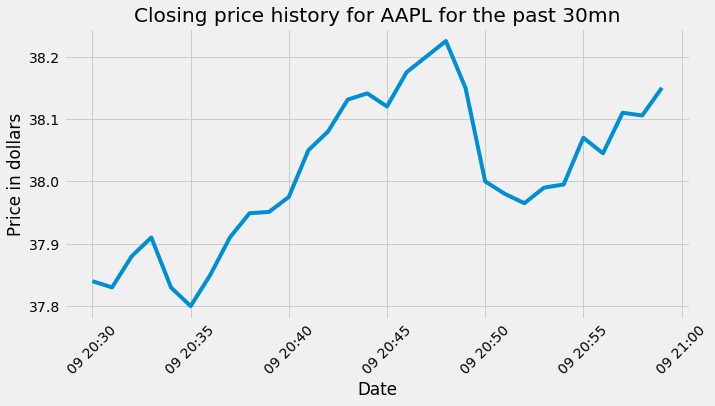

In [40]:
plt.figure(figsize=(10,5))
plt.plot(data['Close'], label='Closing price')
plt.title('Closing price history for AAPL for the past 30mn')
plt.xlabel('Date')
plt.ylabel('Price in dollars')
plt.xticks(rotation=45)
plt.show()

## MACD to know when to buy and sell

In [41]:
ShortEMA = data.Close.ewm(span=12,adjust=False).mean()
LongEMA = data.Close.ewm(span=26,adjust=False).mean()
MACD = ShortEMA - LongEMA
signal = MACD.ewm(span=9, adjust=False).mean()

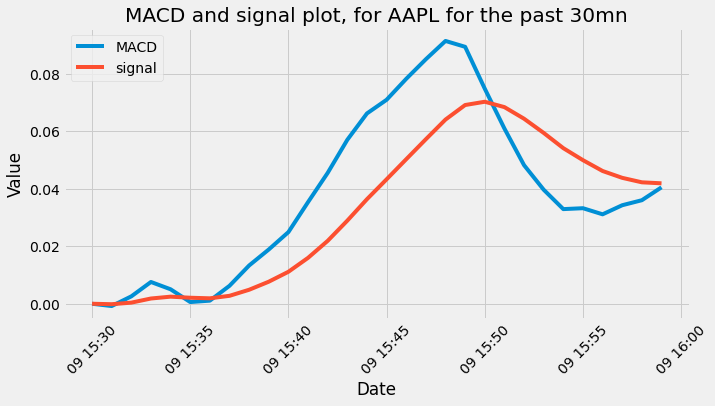

In [42]:
plt.figure(figsize=(10,5))
plt.plot(data.index, MACD, label='MACD')
plt.plot(data.index, signal, label='signal')
plt.title('MACD and signal plot, for AAPL for the past 30mn')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.show()

In [43]:
data['MACD']=MACD
data['signal']=signal    

In [44]:
data

,Open,High,Low,Close,Adj Close,Volume,MACD,signal
Datetime,,,,,,,,
2021-02-09 15:30:00-05:00,37.740002,37.840000,37.740002,37.840000,37.840000,0,0.000000,0.000000
2021-02-09 15:31:00-05:00,37.830002,37.849998,37.770199,37.830002,37.830002,48386,-0.000798,-0.000160
2021-02-09 15:32:00-05:00,37.830002,37.899899,37.825001,37.880001,37.880001,59141,0.002575,0.000387
2021-02-09 15:33:00-05:00,37.889999,37.919998,37.880001,37.910000,37.910000,49580,0.007581,0.001826
2021-02-09 15:34:00-05:00,37.919899,37.939999,37.820000,37.830002,37.830002,65315,0.005036,0.002468
2021-02-09 15:35:00-05:00,37.839901,37.839901,37.770000,37.799999,37.799999,71238,0.000590,0.002093
2021-02-09 15:36:00-05:00,37.796700,37.849998,37.779999,37.849899,37.849899,47753,0.001081,0.001890
2021-02-09 15:37:00-05:00,37.839901,37.919998,37.830101,37.910000,37.910000,71599,0.006248,0.002762
2021-02-09 15:38:00-05:00,37.900002,37.970001,37.881100,37.948898,37.948898,81186,0.013328,0.004875


# Automate our methodology

## Initalizing portfolio and capital

In [45]:
global init_capital
init_capital = 1000

In [46]:
global capital
capital= 1000

In [47]:
portfolio={}
for i in range (0, len(Tickers)):
    portfolio[Tickers[i]]=0

In [48]:
portfolio

{'X': 0, 'DQ': 0, 'RNG': 0}

## Creating functions to get live data and calculate key indicators

In [64]:
#The NY market is opened from 15h30 to 22H FRANCE:
start_time = 16*60  #16h is taken here to start the bot, to have already 30 data points
end_time = 22*60 - 1 #21h59

In [50]:
def for_call():
    if datetime.now().hour*60 +datetime.now().minute not in [start_time, end_time]: # To not do the call at opening and closing of the market
        for ticker in Tickers:
            call(ticker)
    else:
        print("Skipping call due to init or end")

In [51]:
# this function is called at each minute
def call(Ticker):
    global capital
    global portfolio
    #Get data for the last 30mn (to have more then 26 datapoints)
    data = yf.download(tickers=Ticker, period='30m', interval='1m')
    
    #Get the current price
    price=data.tail(1).iloc[0].Close
    time=data.index[0]
    print('START CALL')
    print(datetime.now())
    print('For ticker: '+Ticker+' at '+str(time)+', Price = '+str(price))

    
    #Create the MACD and signal line
    ShortEMA = data.Close.ewm(span=12,adjust=False).mean()
    LongEMA = data.Close.ewm(span=26,adjust=False).mean()
    MACD = ShortEMA - LongEMA
    signal = MACD.ewm(span=9, adjust=False).mean()
    data['MACD']=MACD
    data['signal']=signal
    
    
    #Defining if we buy or sell
   
    last3=data.tail(3)   
    second_to_last=last3.head(1)
    last=last3.head(2).tail(1)
  
    #print(last)
    #print(last)
    #print('Testing MACD')
    print(last3)
    #print('MACD '+str(last.index[0])+' '+str(last.iloc[0]['MACD'])  )
    #print('signal '+str(last.index[0])+' '+str(last.iloc[0]['signal'])  )
    #print('MACD '+str(second_to_last.index[0])+' '+str(second_to_last.iloc[0]['MACD'])  )
    #print('signal '+str(second_to_last.index[0])+' '+str(second_to_last.iloc[0]['signal'])  )
    #print(last.iloc[0]['signal']) 
    #print(second_to_last.iloc[0]['MACD'])  
    #print(second_to_last.iloc[0]['signal']) 
    if (last.iloc[0]['MACD'] > last.iloc[0]['signal'])&(second_to_last.iloc[0]['MACD'] < last.iloc[0]['signal'])&(portfolio[Ticker]==0):#Checking if buy or sell signal      
        Buy(Ticker, price)
        print('END CALL')
    elif (last.iloc[0]['MACD'] < last.iloc[0]['signal'])&(second_to_last.iloc[0]['MACD'] > last.iloc[0]['signal'])&(portfolio[Ticker]!=0):#Checking if buy or sell signal    
        Sell(Ticker, price)
        print('END CALL')
    else:
        print('No stocks bought or sold for '+Ticker)
        print('Capital = '+str(capital))
        print(portfolio)
        print('END CALL')

In [52]:
def for_init_call():
    for ticker in Tickers:
        init_call(ticker)

In [53]:
def init_call(Ticker): #To buy the first time, at 10am (16pm FR)
    #Get data for the last 30mn (to have more then 26 datapoints)
    print('START INIT CALL')
    data = yf.download(tickers=Ticker, period='30m', interval='1m')
    global capital
    global portfolio
    
    #Get the current price
    price=data.tail(1).iloc[0].Close
    time=data.index[0]
    
    print('At initialization, for ticker: '+Ticker+' at '+str(time)+', Price = '+str(price))
    print(datetime.now())
    #Create the MACD and signal line
    ShortEMA = data.Close.ewm(span=12,adjust=False).mean()
    LongEMA = data.Close.ewm(span=26,adjust=False).mean()
    MACD = ShortEMA - LongEMA
    signal = MACD.ewm(span=9, adjust=False).mean()
    data['MACD']=MACD
    data['signal']=signal
        
    last3=data.tail(3)   
    #second_to_last=last3.head(1)
    last=last3.head(2).tail(1)
    
    if last.iloc[0]['MACD'] > last.iloc[0]['signal']:
        Buy(Ticker, price)
        print('END INIT CALL')
    #elif last.iloc[0]['MACD'] < last.iloc[0]['signal']:
     #   Sell(Ticker, price) 
     #   print('END INIT CALL')
    else:
        print('No stocks bought or sold for '+Ticker)
        print('Capital = '+str(capital))
        print(portfolio)
        print('END INIT CALL')

## Create Buy and Sell functions

In [54]:
def Buy(Ticker, price):
    #Defining how many actions are not bought yet
    global capital
    global portfolio
    count=0
    for key, value in portfolio.items():
        if value == 0:
            count=count+1
    
    #Defining how much we will invest in that ticker
    if count==0:
        budget=capital
    else:
        budget=capital/count
    
    #New caiptal
    capital= capital - budget
    
    #Update portfolio
    shares=budget/price
    portfolio[Ticker]=portfolio[Ticker]+shares
    print('BUY '+Ticker)
    print('Buying '+str(shares)+' shares, at the price of '+str(price)+' per share, for a total amount of '+str(budget))
    print(portfolio)
    print("Capital ="+str(capital))   

In [55]:
def Sell(Ticker, price):
    global capital
    global portfolio
    share=portfolio[Ticker]
    amount=price * share
    capital=capital+amount
    portfolio[Ticker]=0
    
    print('SELL '+Ticker)
    print('Selling '+str(share)+' shares, at the price of '+str(price)+' per share, for a total amount of '+str(amount))
    print(portfolio)
    print("Capital = "+str(capital))  

In [56]:
def Sell_all():
    global capital
    global portfolio
    print("SELL ALL")
    for key, value in portfolio.items():     
        data = yf.download(tickers=key, period='1m', interval='1m')
        price=data.tail(1).iloc[0].Close
        amount=value*price
        capital=capital+amount
        portfolio[key]=0
    print('AT THE END OF THE DAY, IN 6 HOURS: ')
    print(portfolio)
    print('Init capital = '+str(init_capital))
    print("Final Capital = "+str(capital))  

## Scheduling calls

In [58]:
#Get the NY time
now = datetime.now(tz=pytz.timezone('US/Eastern'))
now=now.strftime("%H:%M:%S")
now

'08:35:00'

In [67]:
#Scheduling the tasks
schedule.every().day.at("16:00").do(for_init_call) #Initializing 30mns after the opening of the market (10am NY)
schedule.every().minutes.at(":30").do(for_call) #Calling at each minute and 1 sec
schedule.every().day.at("21:59").do(Sell_all) #At the end of the day, sell everything

Every 1 day at 21:59:00 do Sell_all() (last run: [never], next run: 2021-02-10 21:59:00)

In [66]:
#schedule.clear()

# Final classical bot

In [ ]:
while datetime.now().hour*60 +datetime.now().minute>=start_time and datetime.now().hour*60 +datetime.now().minute<=end_time: 
    schedule.run_pending() 
    time.sleep(1)

Skipping call due to init or end
START INIT CALL
[*********************100%***********************]  1 of 1 completed
At initialization, for ticker: X at 2021-02-10 09:32:00-05:00, Price = 16.53969955444336
2021-02-10 16:00:02.574262
BUY X
Buying 20.15353013131269 shares, at the price of 16.53969955444336 per share, for a total amount of 333.3333333333333
{'X': 20.15353013131269, 'DQ': 0, 'RNG': 0}
Capital =666.6666666666667
END INIT CALL
START INIT CALL
[*********************100%***********************]  1 of 1 completed
At initialization, for ticker: DQ at 2021-02-10 09:32:00-05:00, Price = 128.6999969482422
2021-02-10 16:00:02.745204
BUY DQ
Buying 2.5900026514172043 shares, at the price of 128.6999969482422 per share, for a total amount of 333.33333333333337
{'X': 20.15353013131269, 'DQ': 2.5900026514172043, 'RNG': 0}
Capital =333.33333333333337
END INIT CALL
START INIT CALL
[*********************100%***********************]  1 of 1 completed
At initialization, for ticker: RNG at 20

[*********************100%***********************]  1 of 1 completed
START CALL
2021-02-10 16:03:30.598981
For ticker: DQ at 2021-02-10 09:35:00-05:00, Price = 128.81500244140625
                                 Open        High         Low       Close  \
Datetime                                                                    
2021-02-10 10:01:00-05:00  129.339996  129.539993  129.080002  129.080002   
2021-02-10 10:02:00-05:00  129.080002  129.289993  128.990005  129.095001   
2021-02-10 10:03:25-05:00  128.815002  128.815002  128.815002  128.815002   

                            Adj Close  Volume      MACD    signal  
Datetime                                                           
2021-02-10 10:01:00-05:00  129.080002   10200  0.768194  0.847228  
2021-02-10 10:02:00-05:00  129.095001   13352  0.740031  0.825788  
2021-02-10 10:03:25-05:00  128.815002       0  0.687197  0.798070  
No stocks bought or sold for DQ
Capital = 0.0
{'X': 20.15353013131269, 'DQ': 2.5900026514172043

[*********************100%***********************]  1 of 1 completed
START CALL
2021-02-10 16:06:31.073031
For ticker: X at 2021-02-10 09:38:00-05:00, Price = 16.52989959716797
                                Open       High        Low      Close  \
Datetime                                                                
2021-02-10 10:04:00-05:00  16.535999  16.549999  16.530001  16.530001   
2021-02-10 10:05:00-05:00  16.520000  16.549900  16.510000  16.511600   
2021-02-10 10:06:28-05:00  16.529900  16.529900  16.529900  16.529900   

                           Adj Close  Volume      MACD    signal  
Datetime                                                          
2021-02-10 10:04:00-05:00  16.530001   31150 -0.037801 -0.035211  
2021-02-10 10:05:00-05:00  16.511600   30813 -0.038673 -0.035903  
2021-02-10 10:06:28-05:00  16.529900       0 -0.037457 -0.036214  
No stocks bought or sold for X
Capital = 0.0
{'X': 20.15353013131269, 'DQ': 2.5900026514172043, 'RNG': 0.760609560969885}


[*********************100%***********************]  1 of 1 completed
START CALL
2021-02-10 16:11:30.944091
For ticker: DQ at 2021-02-10 09:43:00-05:00, Price = 128.7899932861328
                                 Open        High         Low       Close  \
Datetime                                                                    
2021-02-10 10:09:00-05:00  129.624695  129.669998  129.169998  129.169998   
2021-02-10 10:10:00-05:00  129.059998  129.059998  128.630005  128.716003   
2021-02-10 10:11:27-05:00  128.789993  128.789993  128.789993  128.789993   

                            Adj Close  Volume      MACD    signal  
Datetime                                                           
2021-02-10 10:09:00-05:00  129.169998    5564  0.481491  0.524945  
2021-02-10 10:10:00-05:00  128.716003    9298  0.412165  0.502389  
2021-02-10 10:11:27-05:00  128.789993       0  0.359055  0.473722  
No stocks bought or sold for DQ
Capital = 0.0
{'X': 20.15353013131269, 'DQ': 2.5900026514172043,

[*********************100%***********************]  1 of 1 completed
START CALL
2021-02-10 16:14:30.873753
For ticker: X at 2021-02-10 09:46:00-05:00, Price = 16.440000534057617
                                Open       High        Low      Close  \
Datetime                                                                
2021-02-10 10:12:00-05:00  16.555000  16.558300  16.530001  16.530001   
2021-02-10 10:13:00-05:00  16.525000  16.525000  16.450001  16.459999   
2021-02-10 10:14:28-05:00  16.440001  16.440001  16.440001  16.440001   

                           Adj Close  Volume      MACD    signal  
Datetime                                                          
2021-02-10 10:12:00-05:00  16.530001   33327 -0.017157 -0.020246  
2021-02-10 10:13:00-05:00  16.459999  157760 -0.022610 -0.020719  
2021-02-10 10:14:28-05:00  16.440001       0 -0.028220 -0.022219  
SELL X
Selling 20.15353013131269 shares, at the price of 16.440000534057617 per share, for a total amount of 331.32404612

[*********************100%***********************]  1 of 1 completed
START CALL
2021-02-10 16:19:30.755737
For ticker: RNG at 2021-02-10 09:51:00-05:00, Price = 435.3900146484375
                                 Open        High         Low       Close  \
Datetime                                                                    
2021-02-10 10:17:00-05:00  435.529999  435.890015  435.529999  435.779999   
2021-02-10 10:18:00-05:00  435.510010  435.510010  435.000000  435.000000   
2021-02-10 10:19:22-05:00  435.390015  435.390015  435.390015  435.390015   

                            Adj Close  Volume      MACD    signal  
Datetime                                                           
2021-02-10 10:17:00-05:00  435.779999    2462 -0.337826  0.164337  
2021-02-10 10:18:00-05:00  435.000000    5468 -0.509571  0.029555  
2021-02-10 10:19:22-05:00  435.390015       0 -0.607210 -0.097798  
No stocks bought or sold for RNG
Capital = 997.2597068437165
{'X': 0, 'DQ': 0, 'RNG': 0}
END CA

[*********************100%***********************]  1 of 1 completed
START CALL
2021-02-10 16:22:30.562291
For ticker: RNG at 2021-02-10 09:54:00-05:00, Price = 430.9949951171875
                                 Open        High         Low       Close  \
Datetime                                                                    
2021-02-10 10:20:00-05:00  434.285004  434.285004  433.179688  433.179688   
2021-02-10 10:21:00-05:00  433.480011  434.130005  432.047485  432.047485   
2021-02-10 10:22:19-05:00  430.994995  430.994995  430.994995  430.994995   

                            Adj Close  Volume      MACD    signal  
Datetime                                                           
2021-02-10 10:20:00-05:00  433.179688    5715 -1.109709 -0.517656  
2021-02-10 10:21:00-05:00  432.047485   11615 -1.358260 -0.685777  
2021-02-10 10:22:19-05:00  430.994995       0 -1.621475 -0.872917  
No stocks bought or sold for RNG
Capital = 997.2597068437165
{'X': 0, 'DQ': 0, 'RNG': 0}
END CA

2021-02-10 10:25:24-05:00  121.785004       0 -1.639338 -0.804548  
No stocks bought or sold for DQ
Capital = 997.2597068437165
{'X': 0, 'DQ': 0, 'RNG': 0}
END CALL
[*********************100%***********************]  1 of 1 completed
START CALL
2021-02-10 16:25:31.309331
For ticker: RNG at 2021-02-10 09:57:00-05:00, Price = 426.8550109863281
                                 Open        High         Low       Close  \
Datetime                                                                    
2021-02-10 10:23:00-05:00  430.420013  430.424988  427.010010  427.010010   
2021-02-10 10:24:00-05:00  426.679993  427.029999  426.149994  426.540009   
2021-02-10 10:25:18-05:00  426.855011  426.855011  426.855011  426.855011   

                            Adj Close  Volume      MACD    signal  
Datetime                                                           
2021-02-10 10:23:00-05:00  427.010010    8534 -2.007342 -0.944038  
2021-02-10 10:24:00-05:00  426.540009    6777 -2.427226 -1.240675 

[*********************100%***********************]  1 of 1 completed
START CALL
2021-02-10 16:28:31.090187
For ticker: RNG at 2021-02-10 10:00:00-05:00, Price = 431.0154113769531
                                 Open        High         Low       Close  \
Datetime                                                                    
2021-02-10 10:25:00-05:00  426.899994  428.829987  426.855011  428.829987   
2021-02-10 10:26:00-05:00  429.480011  429.615997  429.220001  429.220001   
2021-02-10 10:27:29-05:00  431.015411  431.015411  431.015411  431.015411   

                            Adj Close  Volume      MACD    signal  
Datetime                                                           
2021-02-10 10:25:00-05:00  428.829987    3576 -2.846969 -1.900150  
2021-02-10 10:26:00-05:00  429.220001    3629 -2.859186 -2.091958  
2021-02-10 10:27:29-05:00  431.015411       0 -2.692951 -2.212156  
No stocks bought or sold for RNG
Capital = 997.2597068437165
{'X': 0, 'DQ': 0, 'RNG': 0}
END CA

[*********************100%***********************]  1 of 1 completed
START CALL
2021-02-10 16:31:30.695358
For ticker: DQ at 2021-02-10 10:03:00-05:00, Price = 123.05999755859375
                                 Open        High         Low       Close  \
Datetime                                                                    
2021-02-10 10:29:00-05:00  125.320000  125.500000  124.690002  124.690002   
2021-02-10 10:30:00-05:00  124.904999  124.904999  124.000000  124.019997   
2021-02-10 10:31:22-05:00  123.059998  123.059998  123.059998  123.059998   

                            Adj Close  Volume      MACD    signal  
Datetime                                                           
2021-02-10 10:29:00-05:00  124.690002    4522 -1.256583 -1.129093  
2021-02-10 10:30:00-05:00  124.019997    3859 -1.252394 -1.153753  
2021-02-10 10:31:22-05:00  123.059998       0 -1.311420 -1.185287  
No stocks bought or sold for DQ
Capital = 332.4199022812388
{'X': 20.263327544499603, 'DQ': 0, 

[*********************100%***********************]  1 of 1 completed
START CALL
2021-02-10 16:34:31.124670
For ticker: X at 2021-02-10 10:06:00-05:00, Price = 16.325000762939453
                                Open       High        Low      Close  \
Datetime                                                                
2021-02-10 10:32:00-05:00  16.379999  16.389900  16.340000  16.340000   
2021-02-10 10:33:00-05:00  16.344999  16.350000  16.309999  16.330099   
2021-02-10 10:34:29-05:00  16.325001  16.325001  16.325001  16.325001   

                           Adj Close  Volume      MACD    signal  
Datetime                                                          
2021-02-10 10:32:00-05:00  16.340000   22166 -0.031174 -0.031895  
2021-02-10 10:33:00-05:00  16.330099   66365 -0.034066 -0.032329  
2021-02-10 10:34:29-05:00  16.325001       0 -0.036350 -0.033133  
No stocks bought or sold for X
Capital = 663.4213391690093
{'X': 0, 'DQ': 0, 'RNG': 0.7695172599823241}
END CALL
[*******

[*********************100%***********************]  1 of 1 completed
START CALL
2021-02-10 16:37:30.411749
For ticker: X at 2021-02-10 10:09:00-05:00, Price = 16.332500457763672
                                Open       High        Low      Close  \
Datetime                                                                
2021-02-10 10:35:00-05:00  16.320000  16.389999  16.315001  16.370001   
2021-02-10 10:36:00-05:00  16.360001  16.400000  16.349501  16.370001   
2021-02-10 10:37:21-05:00  16.332500  16.332500  16.332500  16.332500   

                           Adj Close  Volume      MACD    signal  
Datetime                                                          
2021-02-10 10:35:00-05:00  16.370001   45767 -0.037427 -0.036697  
2021-02-10 10:36:00-05:00  16.370001   61294 -0.034932 -0.036344  
2021-02-10 10:37:21-05:00  16.332500       0 -0.035570 -0.036189  
BUY X
Buying 20.309852152909365 shares, at the price of 16.332500457763672 per share, for a total amount of 331.710669584

[*********************100%***********************]  1 of 1 completed
START CALL
2021-02-10 16:39:30.451081
For ticker: RNG at 2021-02-10 10:11:00-05:00, Price = 433.2099914550781
                                 Open        High         Low       Close  \
Datetime                                                                    
2021-02-10 10:36:00-05:00  432.279999  432.359985  432.279999  432.359985   
2021-02-10 10:37:00-05:00  432.000000  432.000000  432.000000  432.000000   
2021-02-10 10:38:46-05:00  433.209991  433.209991  433.209991  433.209991   

                            Adj Close  Volume      MACD    signal  
Datetime                                                           
2021-02-10 10:36:00-05:00  432.359985    1487 -1.202386 -1.499262  
2021-02-10 10:37:00-05:00  432.000000    1023 -1.059041 -1.411218  
2021-02-10 10:38:46-05:00  433.209991       0 -0.838141 -1.296603  
No stocks bought or sold for RNG
Capital = 331.0252012277127
{'X': 0, 'DQ': 2.697182369212504, 

[*********************100%***********************]  1 of 1 completed
START CALL
2021-02-10 16:45:30.444786
For ticker: X at 2021-02-10 10:17:00-05:00, Price = 16.200000762939453
                                Open       High        Low      Close  \
Datetime                                                                
2021-02-10 10:43:00-05:00  16.254999  16.270000  16.225000  16.225000   
2021-02-10 10:44:00-05:00  16.227501  16.227501  16.174999  16.190001   
2021-02-10 10:45:28-05:00  16.200001  16.200001  16.200001  16.200001   

                           Adj Close  Volume      MACD    signal  
Datetime                                                          
2021-02-10 10:43:00-05:00  16.225000   75204 -0.039773 -0.030390  
2021-02-10 10:44:00-05:00  16.190001   98613 -0.045912 -0.033494  
2021-02-10 10:45:28-05:00  16.200001       0 -0.049400 -0.036676  
No stocks bought or sold for X
Capital = 653.3924289417291
{'X': 0, 'DQ': 0, 'RNG': 0.7695172599823241}
END CALL
[*******

[*********************100%***********************]  1 of 1 completed
START CALL
2021-02-10 16:48:31.024016
For ticker: X at 2021-02-10 10:20:00-05:00, Price = 16.21500015258789
                                Open    High        Low      Close  Adj Close  \
Datetime                                                                        
2021-02-10 10:46:00-05:00  16.200001  16.230  16.190001  16.190001  16.190001   
2021-02-10 10:47:00-05:00  16.190001  16.215  16.180000  16.190001  16.190001   
2021-02-10 10:48:29-05:00  16.215000  16.215  16.215000  16.215000  16.215000   

                           Volume      MACD    signal  
Datetime                                               
2021-02-10 10:46:00-05:00   47250 -0.047239 -0.032941  
2021-02-10 10:47:00-05:00   71618 -0.049248 -0.036202  
2021-02-10 10:48:29-05:00       0 -0.048266 -0.038615  
No stocks bought or sold for X
Capital = 653.3924289417291
{'X': 0, 'DQ': 0, 'RNG': 0.7695172599823241}
END CALL
[*********************10

[*********************100%***********************]  1 of 1 completed
START CALL
2021-02-10 16:51:30.203379
For ticker: X at 2021-02-10 10:23:00-05:00, Price = 16.260000228881836
                                Open   High        Low  Close  Adj Close  \
Datetime                                                                   
2021-02-10 10:49:00-05:00  16.235001  16.26  16.220100  16.25      16.25   
2021-02-10 10:50:00-05:00  16.247900  16.25  16.219999  16.24      16.24   
2021-02-10 10:51:28-05:00  16.260000  16.26  16.260000  16.26      16.26   

                           Volume      MACD    signal  
Datetime                                               
2021-02-10 10:49:00-05:00   33211 -0.031663 -0.024643  
2021-02-10 10:50:00-05:00   27926 -0.029849 -0.025684  
2021-02-10 10:51:28-05:00       0 -0.026491 -0.025845  
No stocks bought or sold for X
Capital = 982.8112186057974
{'X': 0, 'DQ': 0, 'RNG': 0}
END CALL
[*********************100%***********************]  1 of 1 comple

[*********************100%***********************]  1 of 1 completed
START CALL
2021-02-10 16:54:30.752114
For ticker: X at 2021-02-10 10:26:00-05:00, Price = 16.350000381469727
                                Open       High        Low      Close  \
Datetime                                                                
2021-02-10 10:52:00-05:00  16.309999  16.344999  16.290001  16.344999   
2021-02-10 10:53:00-05:00  16.350000  16.370001  16.325001  16.369499   
2021-02-10 10:54:28-05:00  16.350000  16.350000  16.350000  16.350000   

                           Adj Close  Volume      MACD    signal  
Datetime                                                          
2021-02-10 10:52:00-05:00  16.344999   58231 -0.027453 -0.040683  
2021-02-10 10:53:00-05:00  16.369499   36811 -0.017462 -0.036039  
2021-02-10 10:54:28-05:00  16.350000       0 -0.010992 -0.031029  
No stocks bought or sold for X
Capital = 655.2074790705317
{'X': 20.07339060106506, 'DQ': 0, 'RNG': 0}
END CALL
[********

[*********************100%***********************]  1 of 1 completed
START CALL
2021-02-10 16:56:30.874338
For ticker: RNG at 2021-02-10 10:28:00-05:00, Price = 429.3599853515625
                                 Open        High         Low       Close  \
Datetime                                                                    
2021-02-10 10:52:00-05:00  428.394989  428.829987  428.394989  428.730011   
2021-02-10 10:53:00-05:00  428.970001  429.369995  428.970001  429.369995   
2021-02-10 10:55:16-05:00  429.359985  429.359985  429.359985  429.359985   

                            Adj Close  Volume      MACD    signal  
Datetime                                                           
2021-02-10 10:52:00-05:00  428.730011    1234 -1.154831 -0.872975  
2021-02-10 10:53:00-05:00  429.369995     887 -1.044047 -0.907189  
2021-02-10 10:55:16-05:00  429.359985       0 -0.946152 -0.914982  
No stocks bought or sold for RNG
Capital = 327.60373953526585
{'X': 20.07339060106506, 'DQ': 2.

[*********************100%***********************]  1 of 1 completed
START CALL
2021-02-10 17:02:30.938101
For ticker: X at 2021-02-10 10:34:00-05:00, Price = 16.43000030517578
                             Open   High        Low   Close  Adj Close  \
Datetime                                                                 
2021-02-10 11:00:00-05:00  16.400  16.42  16.389999  16.395     16.395   
2021-02-10 11:01:00-05:00  16.395  16.41  16.385000  16.400     16.400   
2021-02-10 11:02:28-05:00  16.430  16.43  16.430000  16.430     16.430   

                           Volume      MACD    signal  
Datetime                                               
2021-02-10 11:00:00-05:00   28619  0.027715  0.012469  
2021-02-10 11:01:00-05:00   13840  0.029888  0.015953  
2021-02-10 11:02:28-05:00       0  0.033643  0.019491  
No stocks bought or sold for X
Capital = 0.0
{'X': 20.07339060106506, 'DQ': 2.703001219341344, 'RNG': 0.7627511013321628}
END CALL
[*********************100%***************

Exception in thread Thread-196:
Traceback (most recent call last):
  File "C:\Users\louis\anaconda3\lib\site-packages\urllib3\connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "C:\Users\louis\anaconda3\lib\site-packages\urllib3\util\connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "C:\Users\louis\anaconda3\lib\socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\louis\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "C:\Users\louis\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 376, in _make_request
    self._validate_conn(conn)
  File "C:\Users\louis\anacond

In [62]:
#First attempt: 08 février 2021. 
#Initial capital: 1000. Final capital: 993.1277610857343. Duration: 3H30.

#Second attempt: 09 février 2021. 
#Improvement of the bot: no more double buying or selling. 
#Initial capital: 1000. Final capital: 1003.8716249651623 . Duration: 5H.

# Reinforcement Learning for trading stocks

## Exploratory analysis of Reinforcement Learning

Libraries used: Tensorflow(DL), OpenAIGym (RL env), gym-anytrading(RL env for trading), stable baselines (RL models), Finta (automatic financial indicators)

### Gather data to train on our tickers

In [115]:
df = yf.download(tickers='AAPL', period='5d', interval='1m')
#Print data
#data=data.set_index(pd.DatetimeIndex(data['Datetime'].values))
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-03-24 09:30:00-04:00,122.820000,122.900002,122.570000,122.610001,122.610001,1812673
2021-03-24 09:31:00-04:00,122.629997,122.769997,122.459999,122.629997,122.629997,356482
2021-03-24 09:32:00-04:00,122.660004,122.680000,122.470001,122.639999,122.639999,329663
2021-03-24 09:33:00-04:00,122.639999,122.690002,122.389999,122.480103,122.480103,387533
2021-03-24 09:34:00-04:00,122.500000,122.500000,122.242996,122.242996,122.242996,310535
...,...,...,...,...,...,...
2021-03-30 14:41:00-04:00,119.654999,119.684998,119.650002,119.679298,119.679298,78352
2021-03-30 14:42:00-04:00,119.678902,119.809998,119.675003,119.730003,119.730003,210274
2021-03-30 14:43:00-04:00,119.720001,119.730003,119.629997,119.650002,119.650002,115946


### Calcul other signals (SMA, RSI, OBV)

In [85]:
df['SMA'] = TA.SMA(df, 12)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0, inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume,SMA,RSI,OBV
Datetime,,,,,,,,,
2021-03-30 09:30:00-04:00,120.110001,120.403099,120.000000,120.139999,120.139999,2323990,0.000000,0.000000,0.0
2021-03-30 09:31:00-04:00,120.150002,120.169998,119.870003,119.871002,119.871002,595853,0.000000,0.000000,-595853.0
2021-03-30 09:32:00-04:00,119.879204,120.050003,119.830002,119.879997,119.879997,441176,0.000000,3.475972,-154677.0
2021-03-30 09:33:00-04:00,119.889999,119.959999,119.800003,119.949997,119.949997,517309,0.000000,25.250995,362632.0
2021-03-30 09:34:00-04:00,119.949997,120.040001,119.839996,119.849998,119.849998,371282,0.000000,18.745258,-8650.0
...,...,...,...,...,...,...,...,...,...
2021-03-30 12:34:00-04:00,119.900002,119.904999,119.800003,119.817299,119.817299,136665,119.831591,49.905035,3096504.0
2021-03-30 12:35:00-04:00,119.820000,119.849998,119.714996,119.760002,119.760002,153723,119.832425,44.516847,2942781.0
2021-03-30 12:36:00-04:00,119.754997,119.819000,119.724998,119.807800,119.807800,77475,119.838200,49.422754,3020256.0


In [116]:
df.shape

(1874, 6)

### Build test environment

In [66]:
env = gym.make('stocks-v0', df=df, frame_bound=(5,100), window_size=5)

In [13]:
#Checking what actions can be taken in the environment
env.action_space

Discrete(2)

NOTE: In the environment, we can only buy or sell, not hold.

info {'total_reward': 0.03820037841796875, 'total_profit': 0.6968481217174236, 'position': 0}


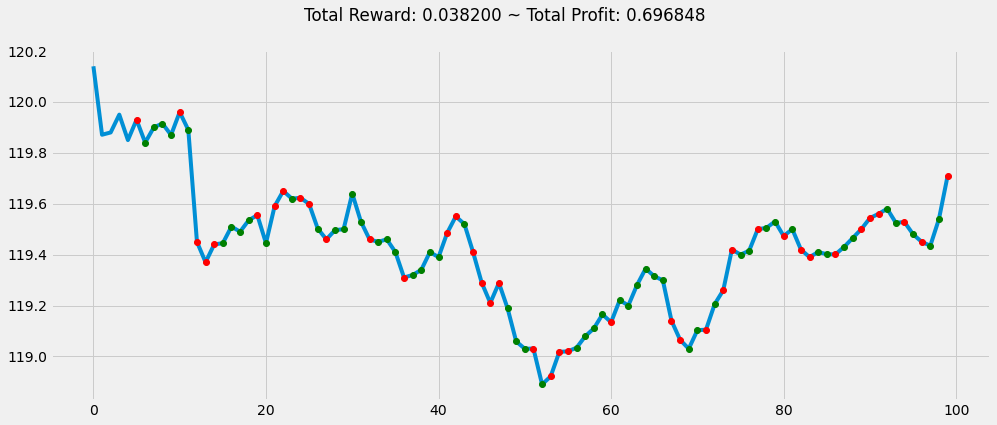

In [14]:
state = env.reset()
while True: 
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

Here we tested the environment while randomly choosing if we buy or sell. The profit is 0.69.

### Creating custom environment to integrate the custom signals.

In [87]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Close', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

Here we decide on how much lines we train, and how much lines are juts looked at at the beginning.

In [88]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals
    
env2 = MyCustomEnv(df=df, window_size=12, frame_bound=(12,50))

### Build and train the  RL model

In [89]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

Here we will try the A2C model from stable baselines for now, but we could try out others.

In [105]:
model = A2C('MlpLstmPolicy', env, verbose=1) 
model.learn(total_timesteps=1000000)

---------------------------------
| explained_variance | -0.0371  |
| fps                | 17       |
| nupdates           | 1        |
| policy_entropy     | 0.693    |
| total_timesteps    | 5        |
| value_loss         | 0.0326   |
---------------------------------
---------------------------------
| explained_variance | 0.287    |
| fps                | 384      |
| nupdates           | 100      |
| policy_entropy     | 0.691    |
| total_timesteps    | 500      |
| value_loss         | 0.0204   |
---------------------------------


KeyboardInterrupt: 

### Evaluating the model

In [91]:
env = MyCustomEnv(df=df, window_size=12, frame_bound=(60,100))
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 0.1167144775390625, 'total_profit': 0.8610080913623506, 'position': 1}


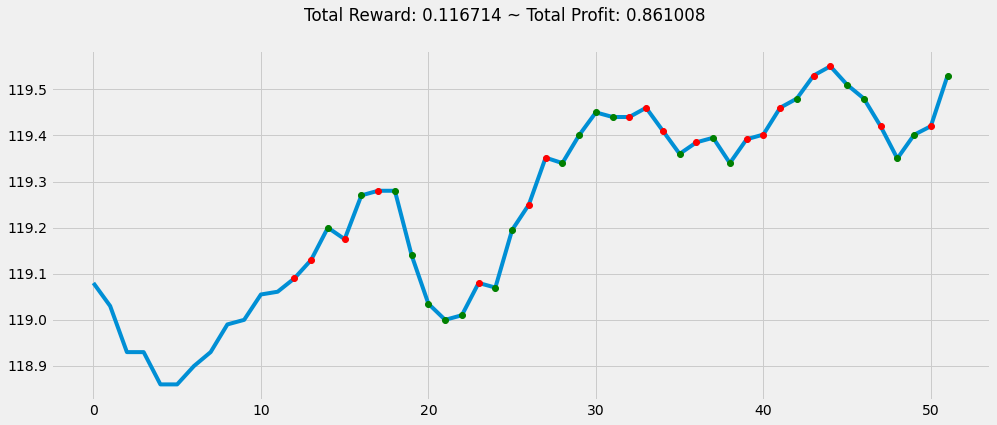

In [92]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

## Final bot for the RL model

This version of the bot is to be run after the closing of the market for now. It gets all the data at the end of the day, iterates through the data.

In [ ]:
#This bot only works (for now) on tickers that have data every minute (the biggest ones). The bot can be manually lauched for a certain ticker at the next cell.
for ticker in Tickers:   
    #Get Data
    df = yf.download(tickers=ticker, period='5d', interval='1m')
    
    #Create signals
    df['SMA'] = TA.SMA(df, 12)
    df['RSI'] = TA.RSI(df)
    df['OBV'] = TA.OBV(df)
    df.fillna(0, inplace=True)
    print(ticker)
    print(df)
    #Creating the environment
    env2 = MyCustomEnv(df=df, window_size=5, frame_bound=(5,20)) #Training over the first 200 minutes of the day
    env_maker = lambda: env2
    env = DummyVecEnv([env_maker])
    
    #Train a model for each ticker
    model = A2C('MlpLstmPolicy', env, verbose=1) 
    model.learn(total_timesteps=1000)
    
    #Evaluate the model
    env = MyCustomEnv(df=df, window_size=5, frame_bound=(20,10)) #Testing for the next 6 hours
    obs = env.reset()
    while True: 
        obs = obs[np.newaxis, ...]
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        if done:
            print("info", info)
            break
            
    #Print the buy and sell of the day for each ticker
    plt.figure(figsize=(15,6))
    plt.title('For the ticker: '+ticker)
    plt.cla()
    env.render_all()
    plt.show()   

In [99]:
Tickers

['GF', 'DQ', 'API']

[*********************100%***********************]  1 of 1 completed
DQ
                                Open       High        Low      Close  \
Datetime                                                                
2021-03-24 09:30:00-04:00  76.860001  76.860001  76.019997  76.385002   
2021-03-24 09:31:00-04:00  76.379997  76.379997  75.279999  75.300003   
2021-03-24 09:32:00-04:00  75.550003  75.709999  75.110001  75.410004   
2021-03-24 09:33:00-04:00  75.610001  75.610001  75.080002  75.475899   
2021-03-24 09:34:00-04:00  75.290001  75.660004  74.894997  75.230003   
...                              ...        ...        ...        ...   
2021-03-30 14:49:00-04:00  68.989998  69.059998  68.980003  69.059998   
2021-03-30 14:50:00-04:00  69.040497  69.070000  69.013603  69.040001   
2021-03-30 14:51:00-04:00  69.040001  69.070000  69.000000  69.019997   
2021-03-30 14:52:00-04:00  69.044998  69.044998  69.000000  69.019997   
2021-03-30 14:53:08-04:00  68.995003  68.995003  68.

---------------------------------
| explained_variance | -0.662   |
| fps                | 456      |
| nupdates           | 2300     |
| policy_entropy     | 0.522    |
| total_timesteps    | 11500    |
| value_loss         | 0.0569   |
---------------------------------
---------------------------------
| explained_variance | -0.818   |
| fps                | 458      |
| nupdates           | 2400     |
| policy_entropy     | 0.65     |
| total_timesteps    | 12000    |
| value_loss         | 0.112    |
---------------------------------
---------------------------------
| explained_variance | -120     |
| fps                | 458      |
| nupdates           | 2500     |
| policy_entropy     | 0.439    |
| total_timesteps    | 12500    |
| value_loss         | 0.00029  |
---------------------------------
---------------------------------
| explained_variance | -1.67    |
| fps                | 459      |
| nupdates           | 2600     |
| policy_entropy     | 0.412    |
| total_timest

---------------------------------
| explained_variance | -417     |
| fps                | 464      |
| nupdates           | 5400     |
| policy_entropy     | 0.00154  |
| total_timesteps    | 27000    |
| value_loss         | 0.000188 |
---------------------------------
---------------------------------
| explained_variance | -34.1    |
| fps                | 463      |
| nupdates           | 5500     |
| policy_entropy     | 0.108    |
| total_timesteps    | 27500    |
| value_loss         | 0.003    |
---------------------------------
---------------------------------
| explained_variance | -531     |
| fps                | 464      |
| nupdates           | 5600     |
| policy_entropy     | 0.00207  |
| total_timesteps    | 28000    |
| value_loss         | 0.000352 |
---------------------------------
---------------------------------
| explained_variance | -6.61    |
| fps                | 464      |
| nupdates           | 5700     |
| policy_entropy     | 0.0012   |
| total_timest

---------------------------------
| explained_variance | -291     |
| fps                | 471      |
| nupdates           | 8400     |
| policy_entropy     | 0.0952   |
| total_timesteps    | 42000    |
| value_loss         | 0.00277  |
---------------------------------
---------------------------------
| explained_variance | -0.27    |
| fps                | 471      |
| nupdates           | 8500     |
| policy_entropy     | 0.391    |
| total_timesteps    | 42500    |
| value_loss         | 1.09     |
---------------------------------
---------------------------------
| explained_variance | 0.513    |
| fps                | 472      |
| nupdates           | 8600     |
| policy_entropy     | 0.0177   |
| total_timesteps    | 43000    |
| value_loss         | 0.00492  |
---------------------------------
----------------------------------
| explained_variance | -4.68e+03 |
| fps                | 472       |
| nupdates           | 8700      |
| policy_entropy     | 0.00217   |
| total_t

---------------------------------
| explained_variance | -225     |
| fps                | 480      |
| nupdates           | 11400    |
| policy_entropy     | 0.00568  |
| total_timesteps    | 57000    |
| value_loss         | 0.000523 |
---------------------------------
----------------------------------
| explained_variance | -3.89e+04 |
| fps                | 480       |
| nupdates           | 11500     |
| policy_entropy     | 0.0057    |
| total_timesteps    | 57500     |
| value_loss         | 0.000449  |
----------------------------------
---------------------------------
| explained_variance | -1.07    |
| fps                | 480      |
| nupdates           | 11600    |
| policy_entropy     | 0.68     |
| total_timesteps    | 58000    |
| value_loss         | 0.0108   |
---------------------------------
---------------------------------
| explained_variance | -125     |
| fps                | 481      |
| nupdates           | 11700    |
| policy_entropy     | 0.00283  |
| tota

---------------------------------
| explained_variance | -57.1    |
| fps                | 485      |
| nupdates           | 14400    |
| policy_entropy     | 4.36e-05 |
| total_timesteps    | 72000    |
| value_loss         | 0.00112  |
---------------------------------
---------------------------------
| explained_variance | -257     |
| fps                | 485      |
| nupdates           | 14500    |
| policy_entropy     | 0.000183 |
| total_timesteps    | 72500    |
| value_loss         | 0.000376 |
---------------------------------
---------------------------------
| explained_variance | -154     |
| fps                | 485      |
| nupdates           | 14600    |
| policy_entropy     | 0.00251  |
| total_timesteps    | 73000    |
| value_loss         | 0.0209   |
---------------------------------
---------------------------------
| explained_variance | -23.5    |
| fps                | 485      |
| nupdates           | 14700    |
| policy_entropy     | 0.00209  |
| total_timest

---------------------------------
| explained_variance | -85.3    |
| fps                | 487      |
| nupdates           | 17400    |
| policy_entropy     | 0.4      |
| total_timesteps    | 87000    |
| value_loss         | 0.0222   |
---------------------------------
---------------------------------
| explained_variance | -8.91    |
| fps                | 487      |
| nupdates           | 17500    |
| policy_entropy     | 0.028    |
| total_timesteps    | 87500    |
| value_loss         | 0.00242  |
---------------------------------
---------------------------------
| explained_variance | -54.1    |
| fps                | 488      |
| nupdates           | 17600    |
| policy_entropy     | 0.00369  |
| total_timesteps    | 88000    |
| value_loss         | 8.08e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.147   |
| fps                | 488      |
| nupdates           | 17700    |
| policy_entropy     | 0.33     |
| total_timest

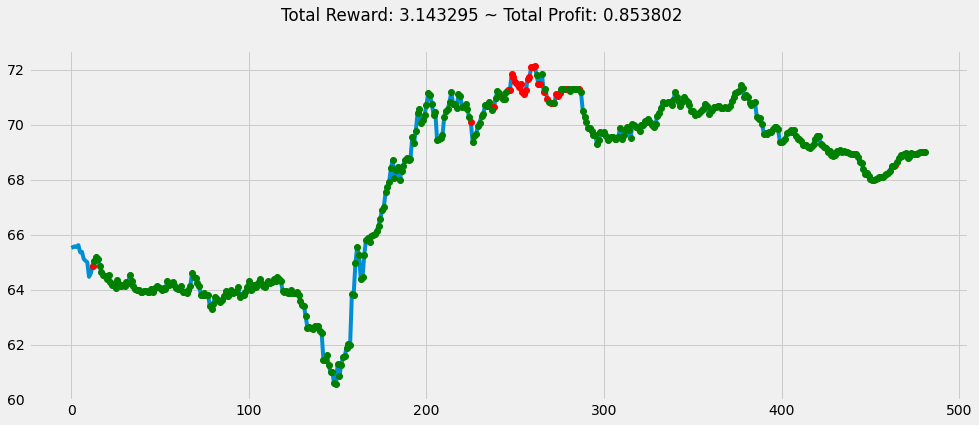

In [118]:
#Get Data
ticker='DQ'
df = yf.download(tickers=ticker, period='5d', interval='1m')

#Create signals
df['SMA'] = TA.SMA(df, 12)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0, inplace=True)
print(ticker)
print(df)
#Creating the environment
env2 = MyCustomEnv(df=df, window_size=12, frame_bound=(12,1400)) #Training over the previous 4 days
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

#Train a model for each ticker
model = A2C('MlpLstmPolicy', env, verbose=1) 
model.learn(total_timesteps=100000)

#Evaluate the model
env = MyCustomEnv(df=df, window_size=12, frame_bound=(1400,18000)) #Testing for today
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
        
#Print the buy and sell of the day for each ticker
plt.figure(figsize=(15,6))
plt.title('For the ticker: '+ticker)
plt.cla()
env.render_all()
plt.show()   

[*********************100%***********************]  1 of 1 completed
API
                                Open       High        Low      Close  \
Datetime                                                                
2021-03-24 09:30:00-04:00  59.389999  59.980000  59.389999  59.689999   
2021-03-24 09:31:00-04:00  59.560001  59.750000  59.450001  59.660000   
2021-03-24 09:32:00-04:00  59.645000  59.645000  59.645000  59.645000   
2021-03-24 09:33:00-04:00  59.506199  59.910000  59.506199  59.720001   
2021-03-24 09:34:00-04:00  59.500000  59.755001  59.450001  59.560001   
...                              ...        ...        ...        ...   
2021-03-30 14:53:00-04:00  49.939999  49.939999  49.900002  49.900002   
2021-03-30 14:54:00-04:00  49.869999  49.869999  49.790001  49.849998   
2021-03-30 14:55:00-04:00  49.820000  49.820000  49.790001  49.790001   
2021-03-30 14:56:00-04:00  49.779999  49.860001  49.779999  49.860001   
2021-03-30 14:57:16-04:00  49.790001  49.790001  49

---------------------------------
| explained_variance | 0.176    |
| fps                | 493      |
| nupdates           | 2300     |
| policy_entropy     | 0.568    |
| total_timesteps    | 11500    |
| value_loss         | 0.0562   |
---------------------------------
---------------------------------
| explained_variance | -0.131   |
| fps                | 493      |
| nupdates           | 2400     |
| policy_entropy     | 0.491    |
| total_timesteps    | 12000    |
| value_loss         | 0.0573   |
---------------------------------
---------------------------------
| explained_variance | 0.11     |
| fps                | 493      |
| nupdates           | 2500     |
| policy_entropy     | 0.597    |
| total_timesteps    | 12500    |
| value_loss         | 0.208    |
---------------------------------
---------------------------------
| explained_variance | 0.0239   |
| fps                | 494      |
| nupdates           | 2600     |
| policy_entropy     | 0.67     |
| total_timest

---------------------------------
| explained_variance | -0.00399 |
| fps                | 499      |
| nupdates           | 5400     |
| policy_entropy     | 0.67     |
| total_timesteps    | 27000    |
| value_loss         | 0.027    |
---------------------------------
---------------------------------
| explained_variance | -1.22    |
| fps                | 500      |
| nupdates           | 5500     |
| policy_entropy     | 0.681    |
| total_timesteps    | 27500    |
| value_loss         | 0.00796  |
---------------------------------
---------------------------------
| explained_variance | -1.09    |
| fps                | 500      |
| nupdates           | 5600     |
| policy_entropy     | 0.66     |
| total_timesteps    | 28000    |
| value_loss         | 0.002    |
---------------------------------
---------------------------------
| explained_variance | -30.5    |
| fps                | 500      |
| nupdates           | 5700     |
| policy_entropy     | 0.67     |
| total_timest

---------------------------------
| explained_variance | -65.5    |
| fps                | 500      |
| nupdates           | 8500     |
| policy_entropy     | 0.599    |
| total_timesteps    | 42500    |
| value_loss         | 0.00275  |
---------------------------------
---------------------------------
| explained_variance | 0.0536   |
| fps                | 500      |
| nupdates           | 8600     |
| policy_entropy     | 0.551    |
| total_timesteps    | 43000    |
| value_loss         | 0.0341   |
---------------------------------
---------------------------------
| explained_variance | -0.0553  |
| fps                | 500      |
| nupdates           | 8700     |
| policy_entropy     | 0.174    |
| total_timesteps    | 43500    |
| value_loss         | 0.000151 |
---------------------------------
---------------------------------
| explained_variance | 0.415    |
| fps                | 500      |
| nupdates           | 8800     |
| policy_entropy     | 0.25     |
| total_timest

---------------------------------
| explained_variance | 0.0672   |
| fps                | 500      |
| nupdates           | 11600    |
| policy_entropy     | 0.352    |
| total_timesteps    | 58000    |
| value_loss         | 0.00444  |
---------------------------------
---------------------------------
| explained_variance | -161     |
| fps                | 500      |
| nupdates           | 11700    |
| policy_entropy     | 0.00122  |
| total_timesteps    | 58500    |
| value_loss         | 0.000235 |
---------------------------------
---------------------------------
| explained_variance | 0.0127   |
| fps                | 500      |
| nupdates           | 11800    |
| policy_entropy     | 0.35     |
| total_timesteps    | 59000    |
| value_loss         | 4.68e-06 |
---------------------------------
---------------------------------
| explained_variance | -0.586   |
| fps                | 500      |
| nupdates           | 11900    |
| policy_entropy     | 0.00159  |
| total_timest

---------------------------------
| explained_variance | -0.0547  |
| fps                | 498      |
| nupdates           | 14700    |
| policy_entropy     | 0.00107  |
| total_timesteps    | 73500    |
| value_loss         | 1.15e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.0543  |
| fps                | 498      |
| nupdates           | 14800    |
| policy_entropy     | 0.000762 |
| total_timesteps    | 74000    |
| value_loss         | 2.83e-07 |
---------------------------------
---------------------------------
| explained_variance | -0.446   |
| fps                | 497      |
| nupdates           | 14900    |
| policy_entropy     | 0.552    |
| total_timesteps    | 74500    |
| value_loss         | 0.000864 |
---------------------------------
----------------------------------
| explained_variance | -1.85e+04 |
| fps                | 497       |
| nupdates           | 15000     |
| policy_entropy     | 0.00144   |
| total_t

---------------------------------
| explained_variance | -730     |
| fps                | 492      |
| nupdates           | 17700    |
| policy_entropy     | 0.593    |
| total_timesteps    | 88500    |
| value_loss         | 0.00266  |
---------------------------------
---------------------------------
| explained_variance | -0.0787  |
| fps                | 490      |
| nupdates           | 17800    |
| policy_entropy     | 0.000749 |
| total_timesteps    | 89000    |
| value_loss         | 1.38e-06 |
---------------------------------
---------------------------------
| explained_variance | -0.00771 |
| fps                | 490      |
| nupdates           | 17900    |
| policy_entropy     | 0.684    |
| total_timesteps    | 89500    |
| value_loss         | 0.00938  |
---------------------------------
---------------------------------
| explained_variance | -48.6    |
| fps                | 489      |
| nupdates           | 18000    |
| policy_entropy     | 0.00164  |
| total_timest

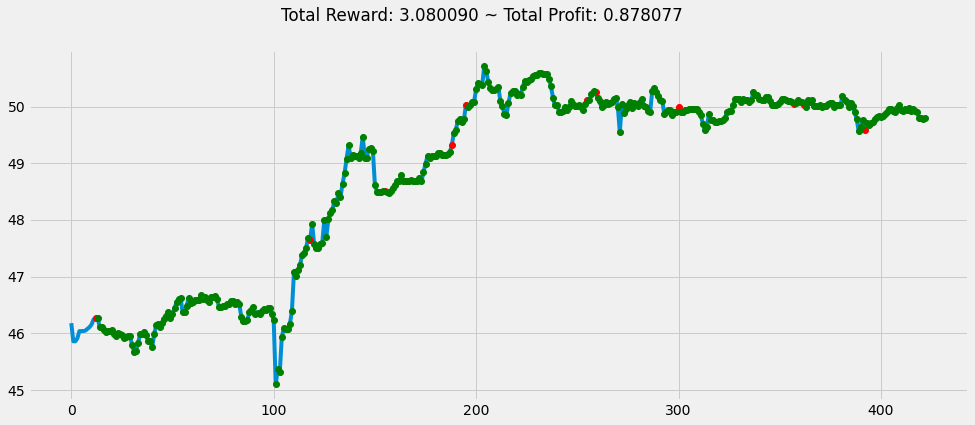

In [119]:
#Get Data
ticker='API'
df = yf.download(tickers=ticker, period='5d', interval='1m')

#Create signals
df['SMA'] = TA.SMA(df, 12)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0, inplace=True)
print(ticker)
print(df)
#Creating the environment
env2 = MyCustomEnv(df=df, window_size=12, frame_bound=(12,1400)) 
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

#Train a model for each ticker
model = A2C('MlpLstmPolicy', env, verbose=1) 
model.learn(total_timesteps=100000)

#Evaluate the model
env = MyCustomEnv(df=df, window_size=12, frame_bound=(1400,18000)) 
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
        
#Print the buy and sell of the day for each ticker
plt.figure(figsize=(15,6))
plt.title('For the ticker: '+ticker)
plt.cla()
env.render_all()
plt.show()  